In [1]:
%reset -sf

import tensorflow as tf
print("Tensorflow:", tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_376 / 2# Set the memory limit in MB
        # memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-12-22 15:08:53.455373: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 15:08:53.478562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
1 Physical GPUs, 1 Logical GPU


2024-12-22 15:08:54.681601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import gc
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()
# additional variable to check the neutrinos
truth_lead_nu = data.Truth_lead_nu()
print(truth_lead_nu.__dir__())
truth_sublead_nu = data.Truth_sublead_nu()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']
['__module__', 'px', 'py', 'pz', 'energy', 'pt', 'eta', 'phi', 'p4', 'p3', '__dict__', '__weakref__', '__doc__', '__dataclass_params__', '__dataclass_fields__', '__init__', '__repr__', '__eq__', '__hash__', '__match_args__', '__new__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__ne__', '__gt__', '__ge__', '__reduce_ex__', '__reduce__', '__getstate__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [4]:
# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > 22
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > 15
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > 10
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > 20
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > -9999
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))

0
0
0
0
0


In [5]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        # lead_lep.pz,
        # lead_lep.energy,
        np.log(lead_lep.energy),
        # np.log(lead_lep.pt),
        lead_lep.eta,
        # lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        # sublead_lep.pz,
        # sublead_lep.energy,
        np.log(sublead_lep.energy),
        # np.log(sublead_lep.pt),
        sublead_lep.eta,
        # sublead_lep.phi,
        met.px,
        met.py,
        # met.pt,
        # met.phi,
        # dilep.px,
        # dilep.py,
        # dilep.pz,
        # np.log(dilep.energy),
        # dilep.pt,
        # dilep.eta,
        # dilep.phi,
        # dilep.m,
    )
)[PRE_CUT]

# weights
mc_weight = data.MC_weight()
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

ROBUST_OBS = StandardScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1008897, 10)
<class 'numpy.ndarray'>


In [6]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (1008897, 8)
<class 'numpy.ndarray'>


In [41]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 1008897
X (Interest)
Training data shape: (807117, 10);
Validing data shape: (100890, 10);
Testing data shape: (100890, 10).
Y (Observed)
Training data shape: (807117, 8);
Validing data shape: (100890, 8);
Testing data shape: (100890, 8).


In [8]:
# # clear cache

# del (
#     lead_lep,
#     sublead_lep,
#     met,
#     truth_lead_lep,
#     truth_sublead_lep,
#     Truth_dilep,
#     truth_met,
#     w_lead,
#     w_sublead,
# )

# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
# # Clear matplotlib cache if used
# try:
#     plt.close('all')
# except ImportError:
#     pass

# # Clear TensorFlow cache if used
# try:
#     tf.keras.backend.clear_session()
# except ImportError:
#     pass

# # Run garbage collection
# gc.collect()

0

In [9]:
# training variables
BATCH_SIZE = 4096
EPOCHS = 1024
LEARNING_RATE = 5e-4

In [10]:
def dense_dropout_block(x, units, activation="elu", dropout_rate=0.2, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(l2=l2),
    )(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


def residual_block(x, units, activation="elu", dropout_rate=0.0, l2=0.0):
    x = dense_dropout_block(
        x, units, dropout_rate=dropout_rate, activation=activation, l2=l2
    )
    y = dense_dropout_block(
        x, units // 2, dropout_rate=dropout_rate, activation=activation, l2=l2 / 2
    )
    y = dense_dropout_block(
        y, units, dropout_rate=dropout_rate, activation=activation, l2=l2
    )
    z = tf.keras.layers.Add()([x, y])
    z = tf.keras.layers.Activation(activation)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    return z


def build_model():
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # construct the model
    for _ in range(2):
        x = residual_block(x, 64, dropout_rate=0.0, l2=0.0)
        x = residual_block(x, 128, dropout_rate=0.1, l2=0.0)  # 0.04
        x = residual_block(x, 32, dropout_rate=0.0, l2=0.0)

    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
# Make a directory
dir_name = HOME_PATH + "/8th_trial/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

In [9]:
# predict
model = tf.keras.models.load_model(dir_name + name + ".keras")
sig_pred_inv = model.predict(obs_kin).reshape(int_kin.shape)
sig_truth_inv = int_kin.copy()

    1/31529 ━━━━━━━━━━━━━━━━━━━━ 3:22:21 385ms/step

I0000 00:00:1734880145.366868  225477 service.cc:145] XLA service 0x7b7ee401f160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734880145.366888  225477 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-22 15:09:05.373865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-22 15:09:05.426396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1734880145.549008  225477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31529/31529 ━━━━━━━━━━━━━━━━━━━━ 27s 850us/step


Truth mean: 0.042, std: 39.067, min: -801.032, max: 803.254


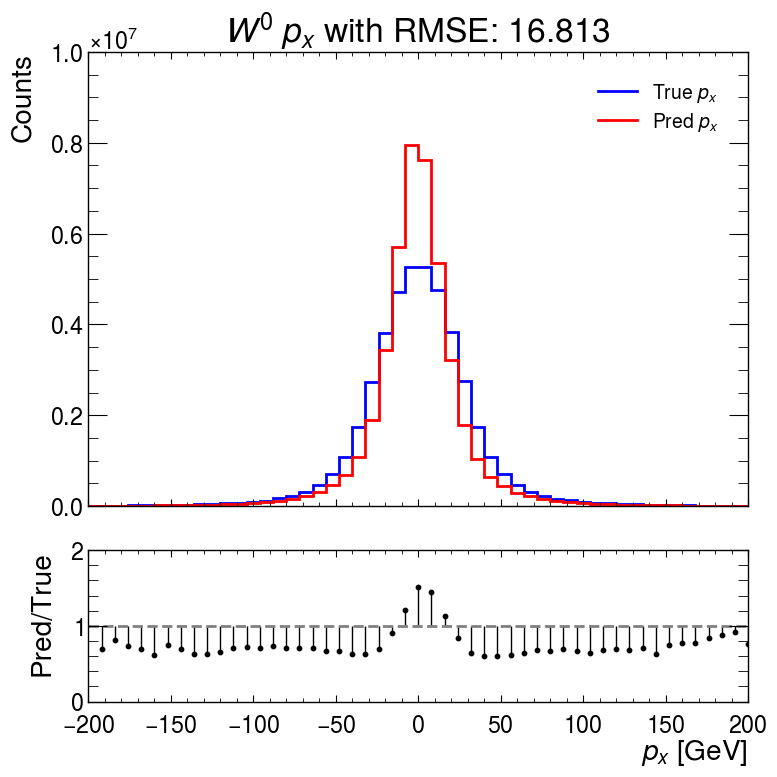

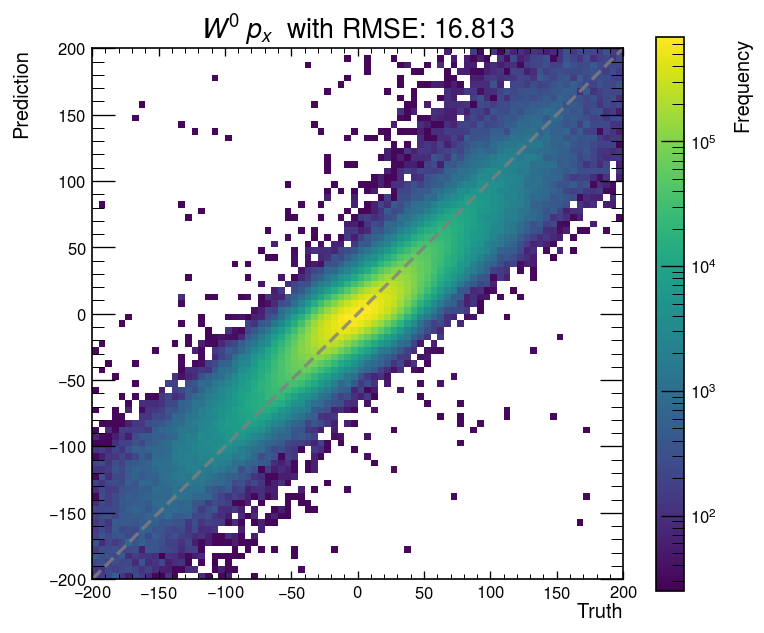

In [10]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$W^{0}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
    # bins = 50
)

Truth mean: -0.006, std: 27.310, min: -595.943, max: 473.069


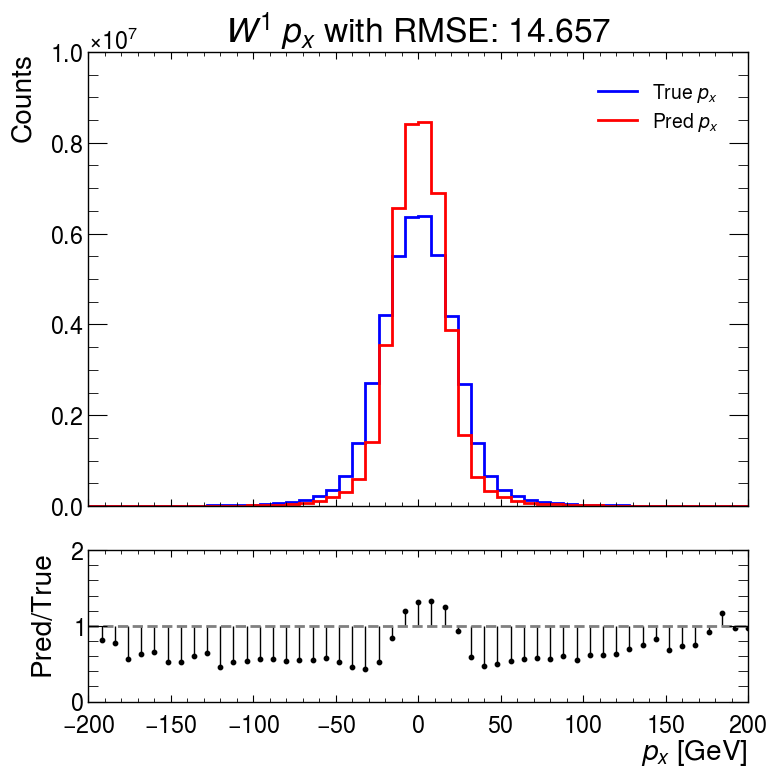

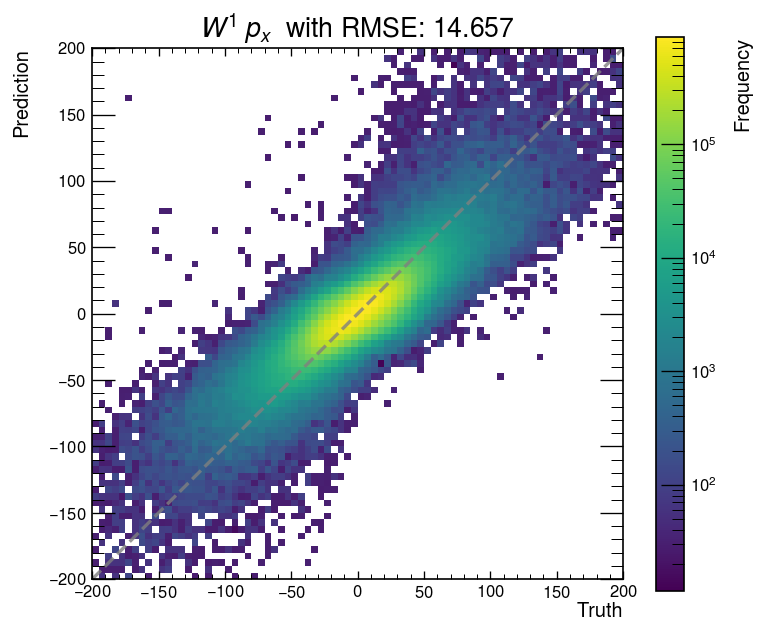

In [11]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
    label=r"$p_{x}$",
    title="$W^{1}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 4],
    sig_pred_inv[:, 4],
    r"$W^{1}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: 0.055, std: 39.041, min: -755.579, max: 760.803


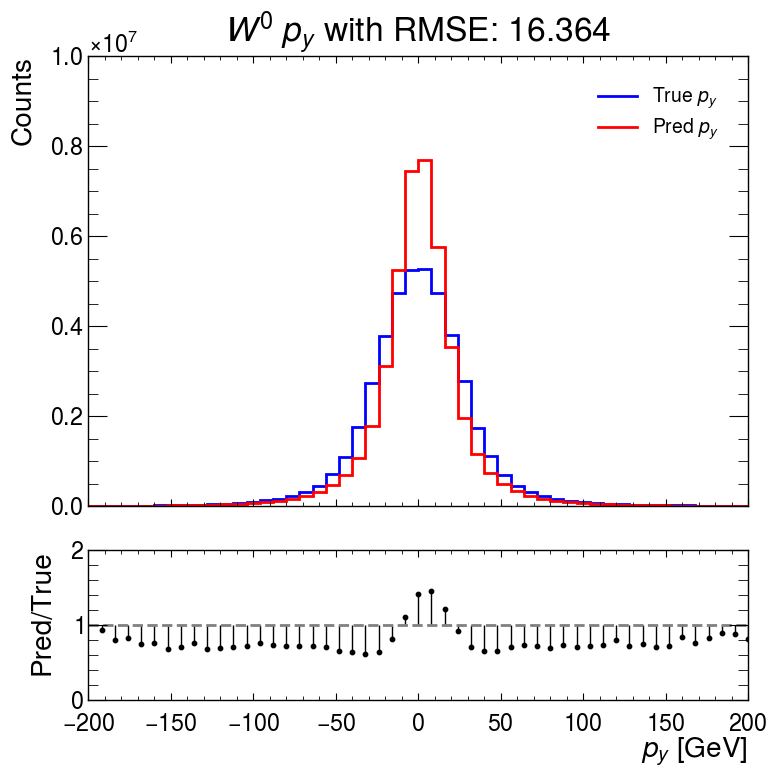

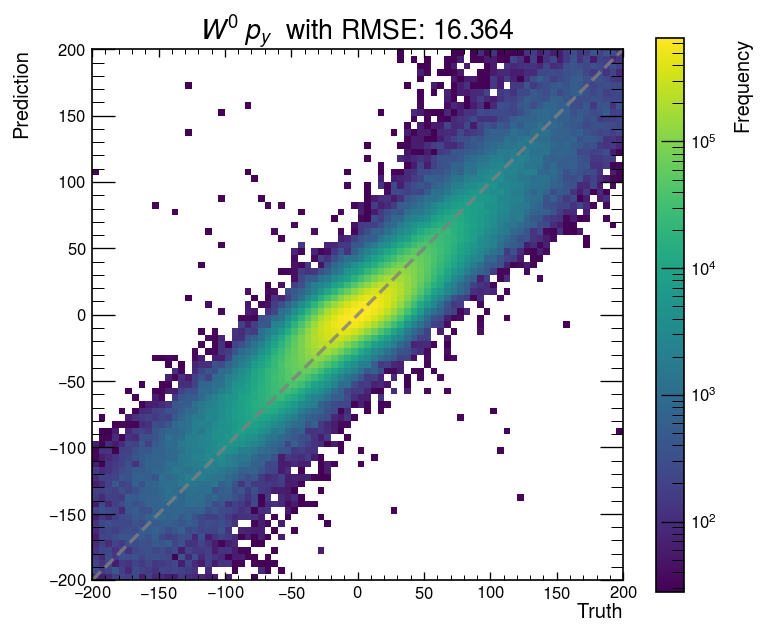

In [12]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{0}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: 0.015, std: 27.409, min: -505.011, max: 599.582


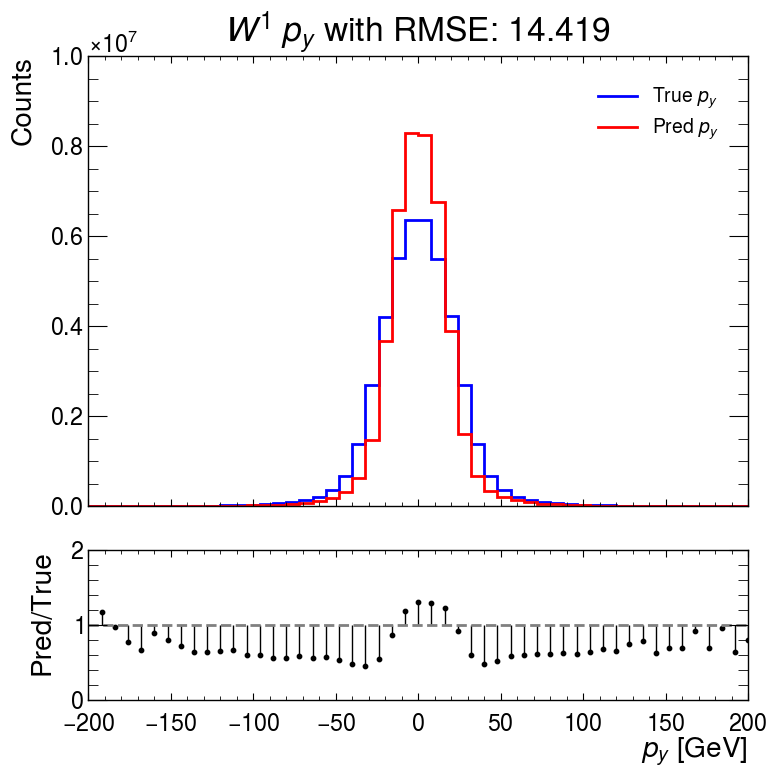

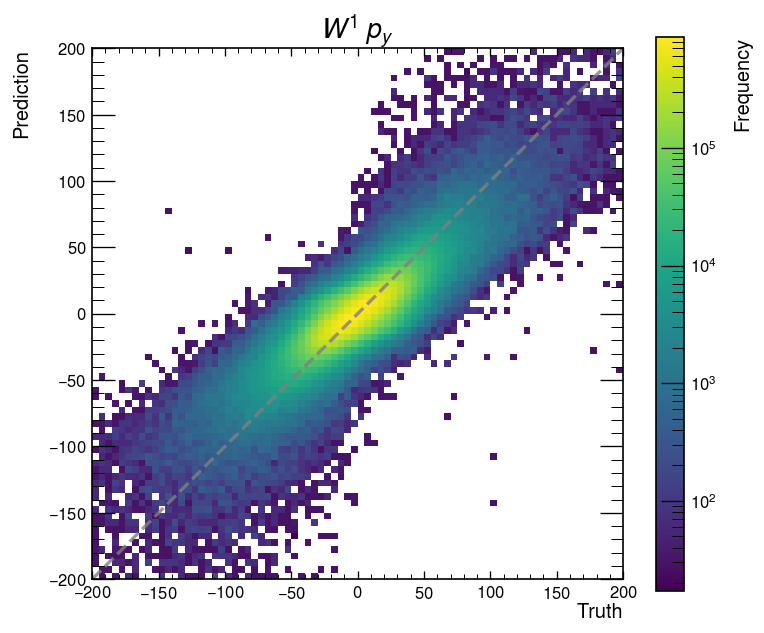

In [13]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}$",
    title="$W^{1}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"$W^{1}$ $p_{y}$ ",
    # + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,5], sig_pred_inv[:,5])[0]:.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: 0.025, std: 172.772, min: -1872.559, max: 2266.587


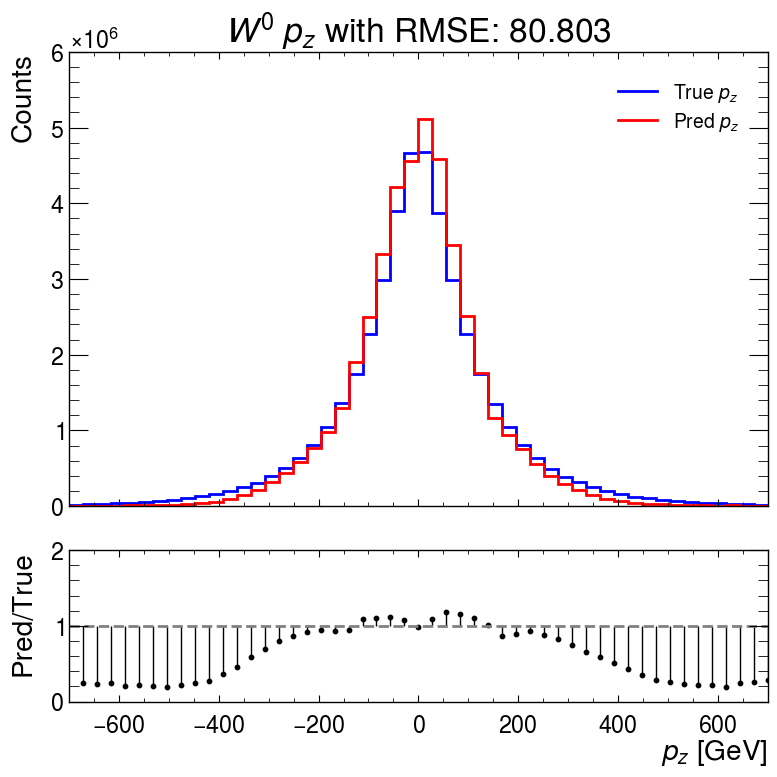

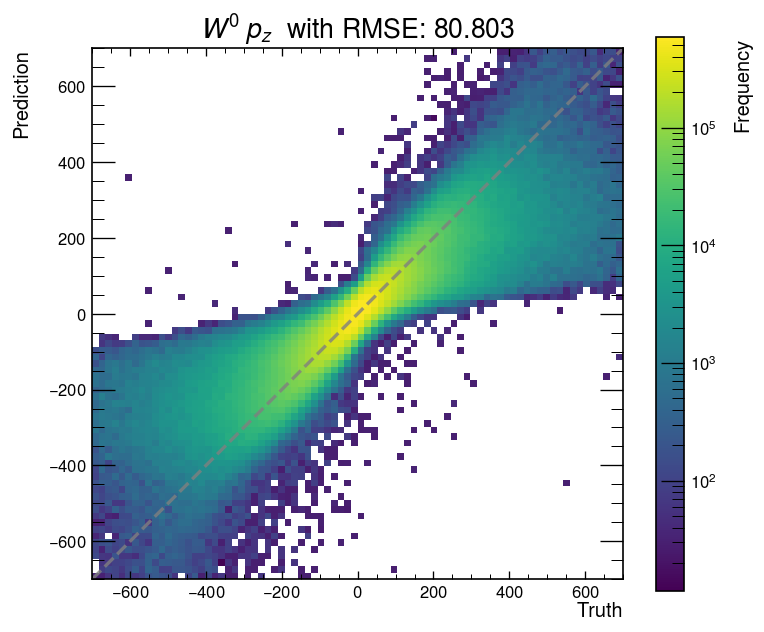

In [14]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$W^{0}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: -0.039, std: 111.565, min: -1631.701, max: 1732.581


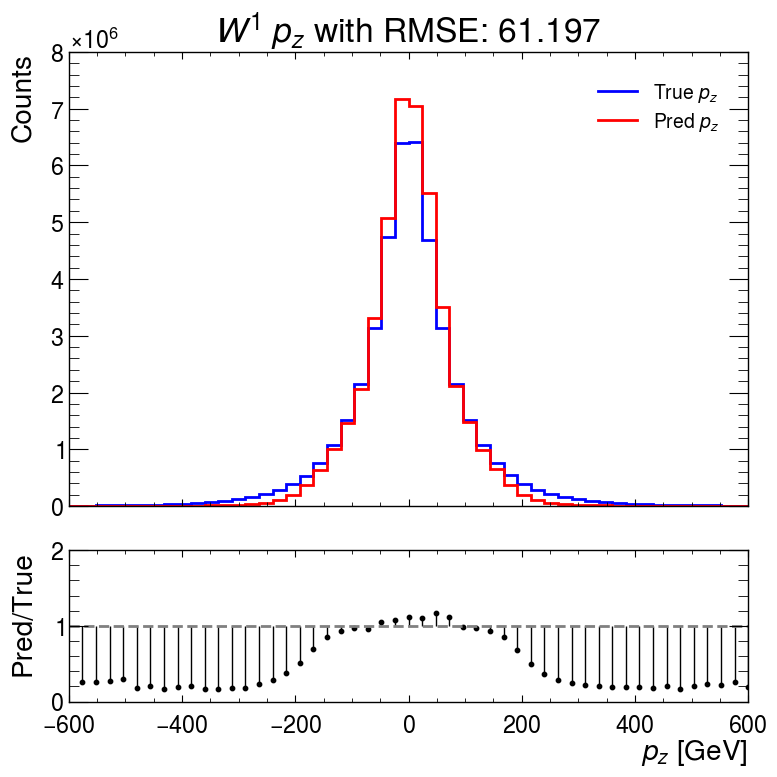

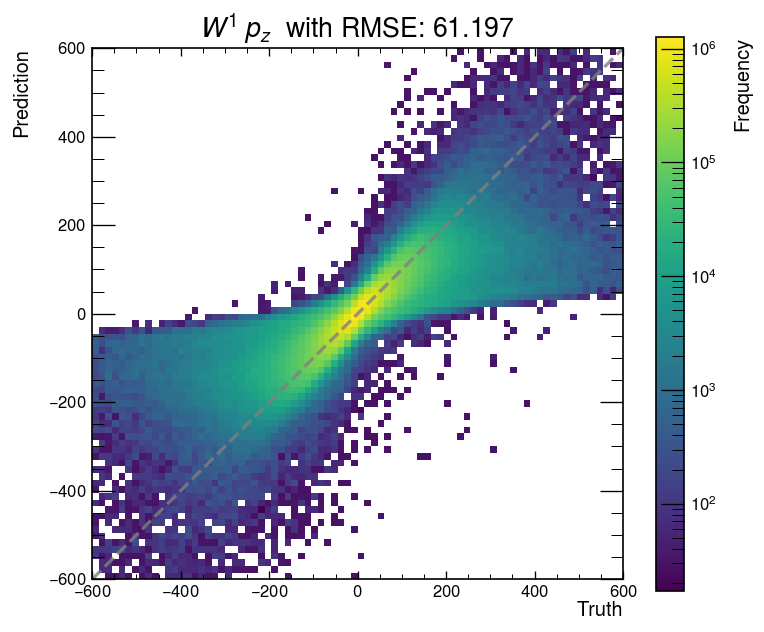

In [15]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$p_{z}$",
    title="$W^{1}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"$W^{1}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: 159.130, std: 113.432, min: 21.707, max: 2304.674


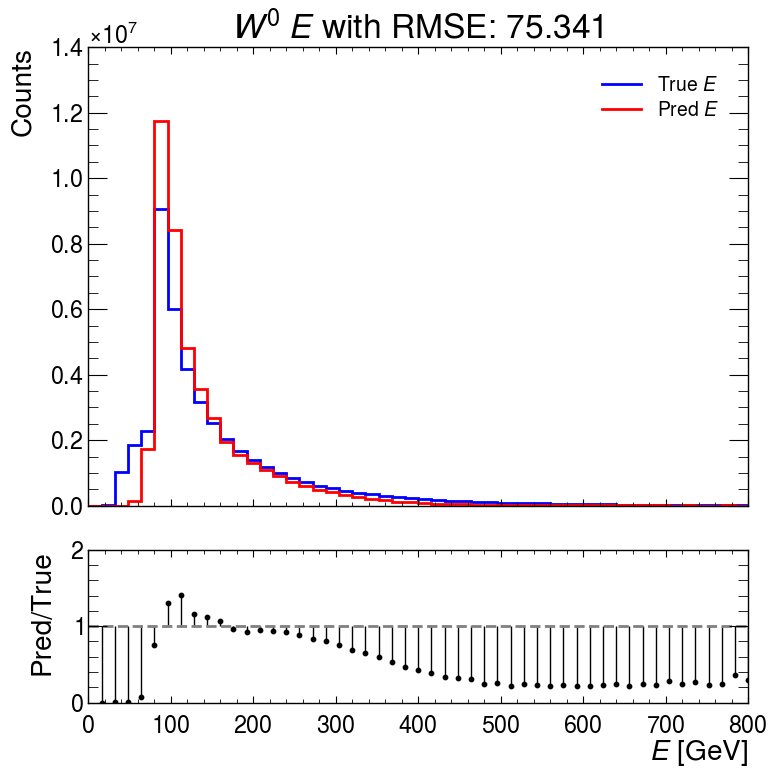

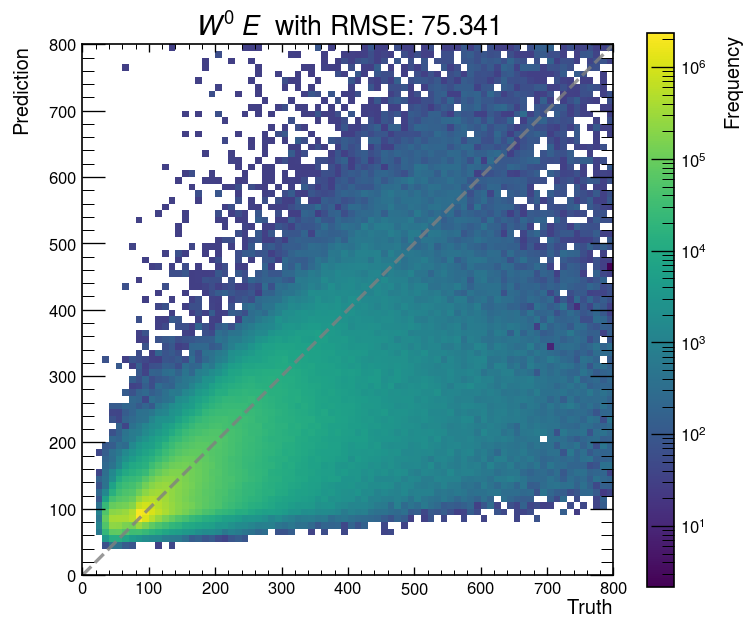

In [16]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$W^{0}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

Truth mean: 99.022, std: 77.970, min: 16.075, max: 1735.346


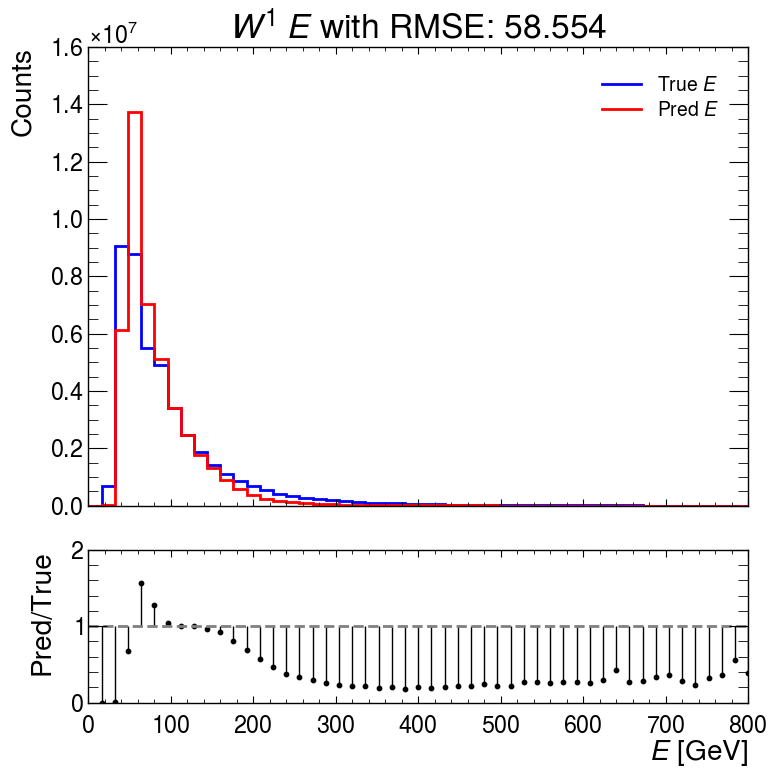

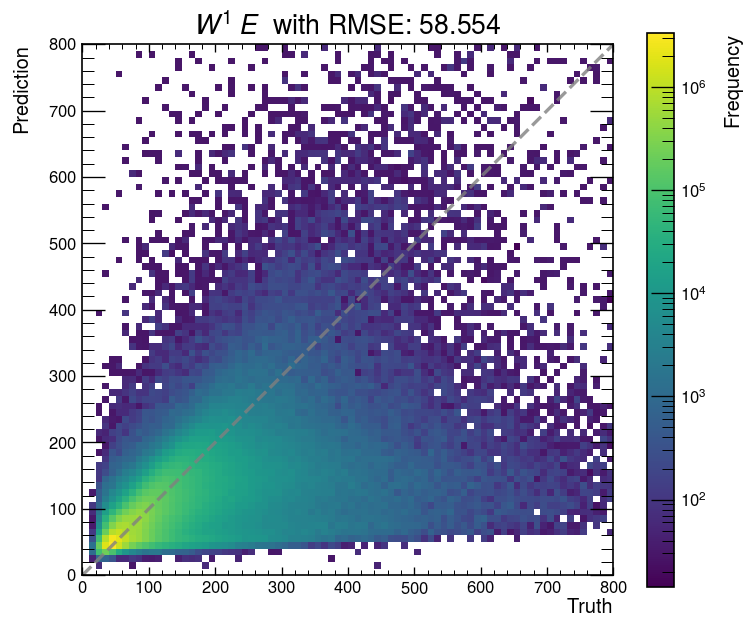

In [17]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="$W^{1}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=mc_weight)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"$W^{1}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=mc_weight)):.3f}",
    range=set_range,
    weights=mc_weight,
)

In [18]:
w_lead_m = data.Lead_w().m
w_sublead_m = data.Sublead_w().m

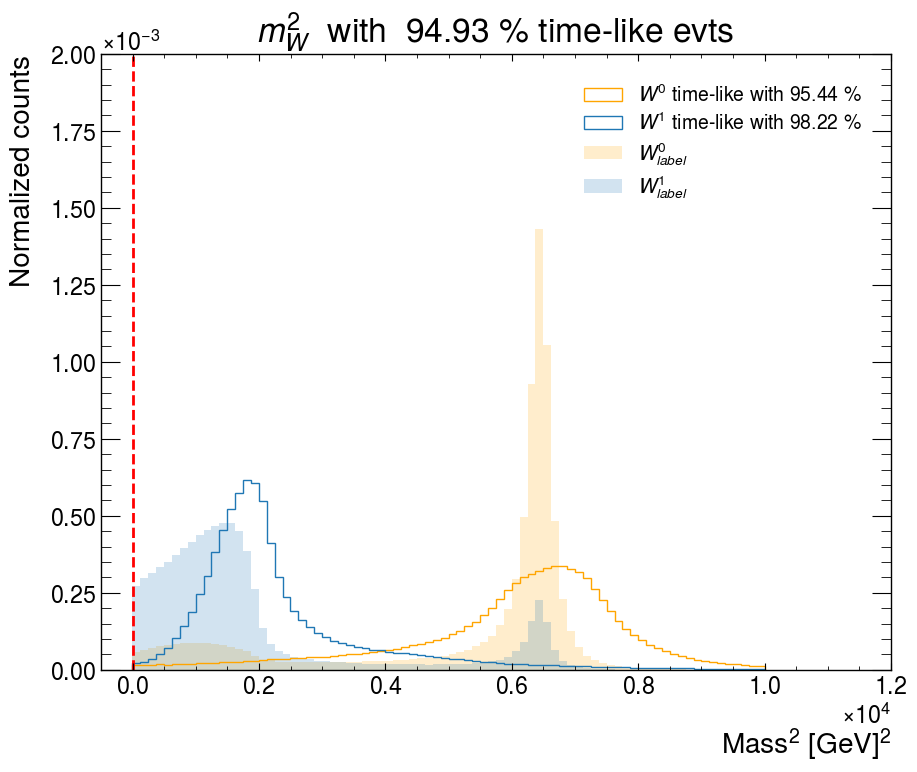

In [19]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$ "
    + f"time-like with {100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} %",
    density=True,
    weights=mc_weight,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$ "
    + f"time-like with {100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} %",
    density=True,
    weights=mc_weight,
)
plt.hist(
    np.square(w_lead_m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{0}$",
    density=True,
    weights=mc_weight,
)
plt.hist(
    np.square(w_sublead_m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{1}$",
    density=True,
    weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like evts"
)
plt.legend(loc="upper right")
plt.show()

Truth mean: 3614.582, std: 2591.740, min: 4.006, max: 11833.121


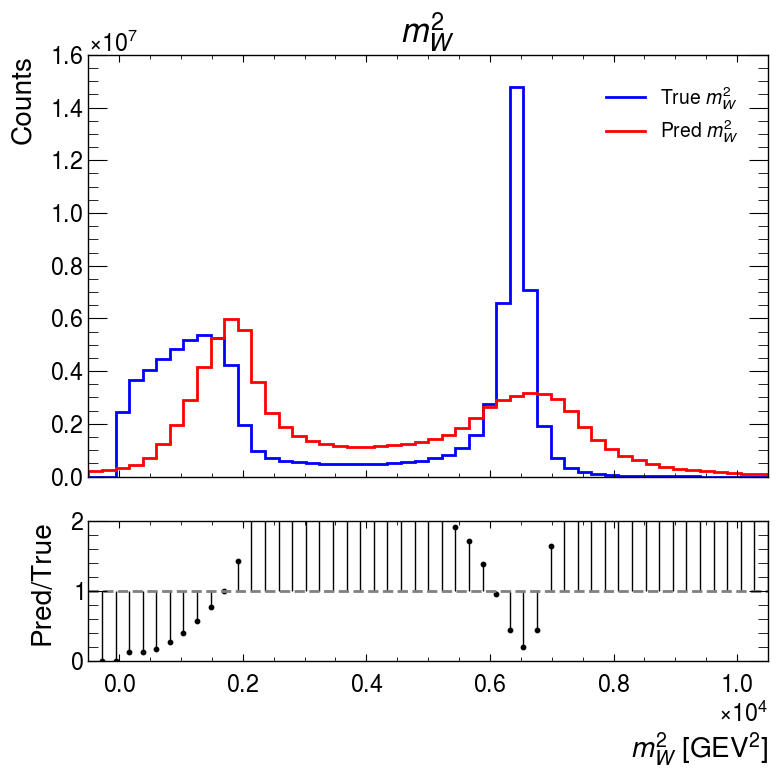

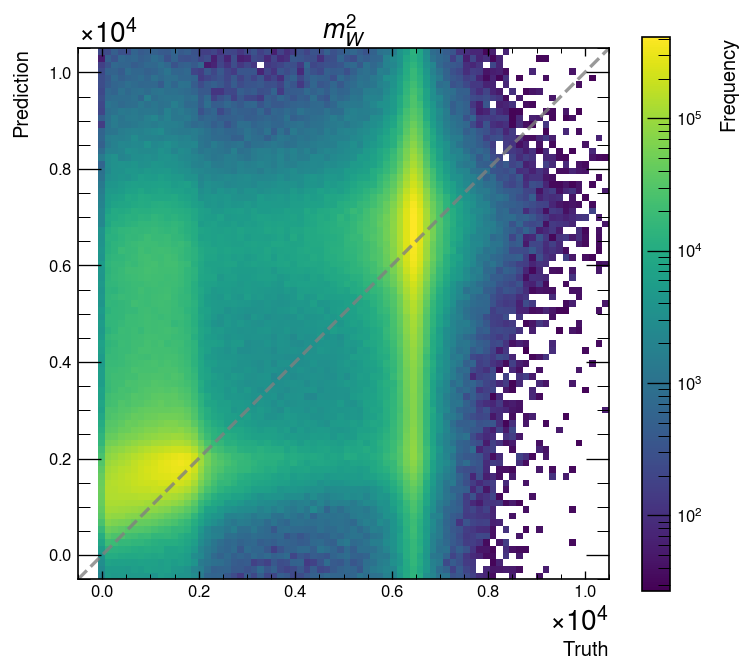

In [20]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate([np.square(w_lead_m), np.square(w_sublead_m)], axis=-1)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
    weights=np.append(mc_weight, mc_weight),
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
    weights=np.append(mc_weight, mc_weight),
)

In [21]:
# only consider 4-dim leading lepton kinematics
def rc(truth, pred):
    # Compute the ratio of prediction to truth --> rc
    # Parameters
    min_data = np.min([pred.min(), truth.min()])
    max_data = np.min([pred.max(), truth.max()])
    min_range = np.arange(min_data, -500, 200).tolist()
    mid_range = np.arange(-500, 10, 150).tolist()
    ranges = np.arange(10, 500, 50).tolist()
    max_range = np.arange(500, max_data, 200).tolist()
    bins = [min_range + mid_range + ranges + max_range]
    print(len(bins[0]))
    print(bins[0])
    print(min_data, max_data)
    n_dim_temp = pred.shape[-1]
    bins_num_temp = bins * n_dim_temp

    truth_hist_temp, edges_temp = np.histogramdd(
        truth,
        bins=bins_num_temp,
        density=False,
    )
    pred_hist_temp, _ = np.histogramdd(
        pred,
        bins=bins_num_temp,
        density=False,
    )

    rc = np.divide(
        truth_hist_temp,
        pred_hist_temp,
        out=np.ones_like(truth_hist_temp),
        where=pred_hist_temp != 0,
    )
    return rc, edges_temp, bins_num_temp


# Digitize the data --> retrivr corresponding position in the 4-d histogram
def digitize_data(data, rc, edges):
    n_dim = data.shape[-1]
    digitized = np.zeros_like(data, dtype=int)
    for dim in range(n_dim):
        digitized[:, dim] = np.digitize(data[:, dim], edges[dim]) - 1
        digitized[:, dim] = np.clip(digitized[:, dim], 0, len(edges[dim]) - 2)
    # Extract the reweighting coefficients for each data point
    reweighting_coefficients = np.array(
        [rc[tuple(digitized[i])] for i in range(data.shape[0])]
    )
    return reweighting_coefficients


dimensionality = 4

rc_w0, edges_w0, bins_w0 = rc(
    sig_truth_inv[:, 0:dimensionality], sig_pred_inv[:, 0:dimensionality]
)
reweighting_coefficients = digitize_data(
    sig_pred_inv[:, 0:dimensionality], rc_w0, edges_w0
)

31
[-1872.5585, -1672.5585, -1472.5585, -1272.5585, -1072.5585, -872.5585000000001, -672.5585000000001, -500, -350, -200, -50, 10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 500.0, 700.0, 900.0, 1100.0, 1300.0, 1500.0, 1700.0, 1900.0, 2100.0, 2300.0]
-1872.5585 2304.674


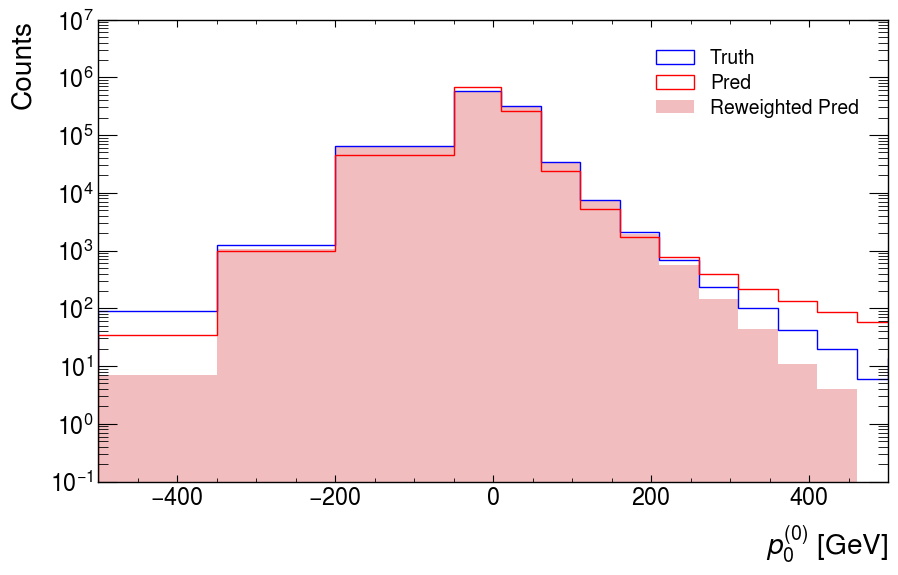

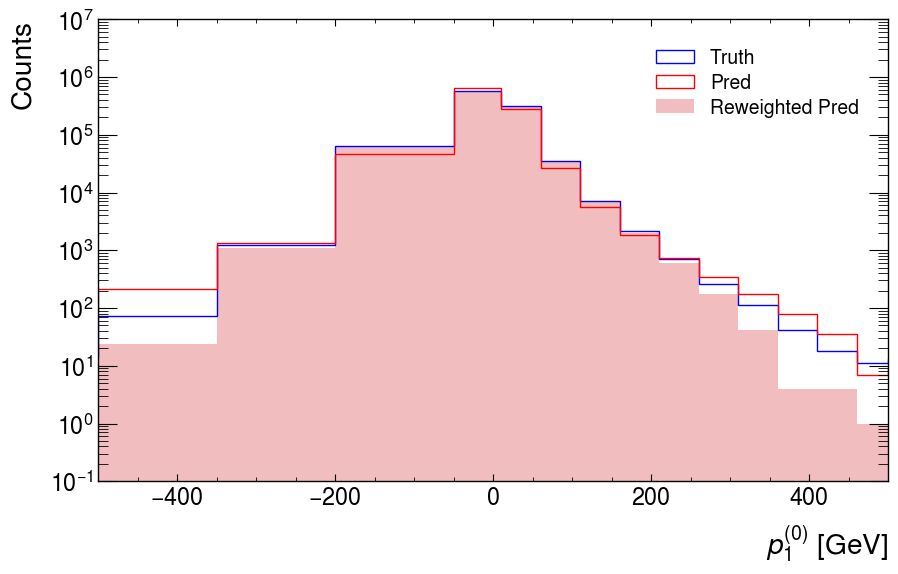

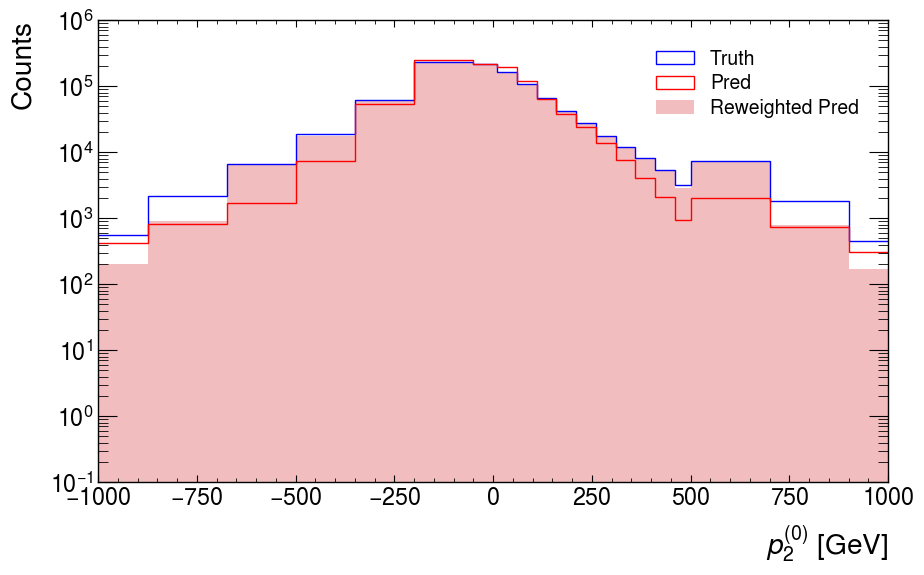

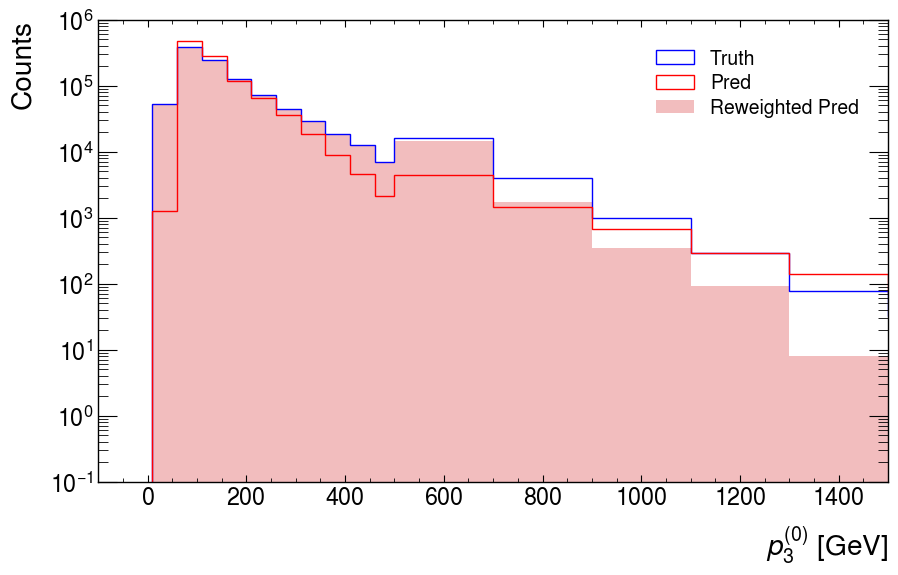

In [22]:
# Calculate the original histograms
n_dims = sig_pred_inv[:, 0:dimensionality].shape[1]
# bins_num = [251] * n_dims
# bins_range = [(-200, 200), (-200, 200), (-600, 600), (0, 600)] * n_dims


def calculate_histograms(data, weights=None):
    return [
        np.histogram(data[:, i], bins=bins_w0[0], weights=weights)[0]
        for i in range(n_dims)
    ]


truth_hist = calculate_histograms(sig_truth_inv[:, 0:4])
pred_hist = calculate_histograms(sig_pred_inv[:, 0:4])
reweighted_hist = calculate_histograms(
    sig_pred_inv[:, 0:4], weights=reweighting_coefficients
)

# Plot the histograms
plot_bins_range = [(-500, 500), (-500, 500), (-1000, 1000), (-100, 1500)]
for dim in range(n_dims):
    plt.figure(figsize=(10, 6))
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=truth_hist[dim],
        histtype="step",
        label="Truth",
        color="blue",
        density=False,
    )
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=pred_hist[dim],
        histtype="step",
        label="Pred",
        color="red",
        density=False,
    )
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=reweighted_hist[dim],
        histtype="bar",
        label="Reweighted Pred",
        color="tab:red",
        alpha=0.3,
        density=False,
    )
    plt.semilogy()
    plt.xlim(plot_bins_range[dim])
    plt.xlabel(f"$p^{{(0)}}_{dim}$ [GeV]")
    plt.ylabel("Counts")
    plt.legend()
    plt.show()

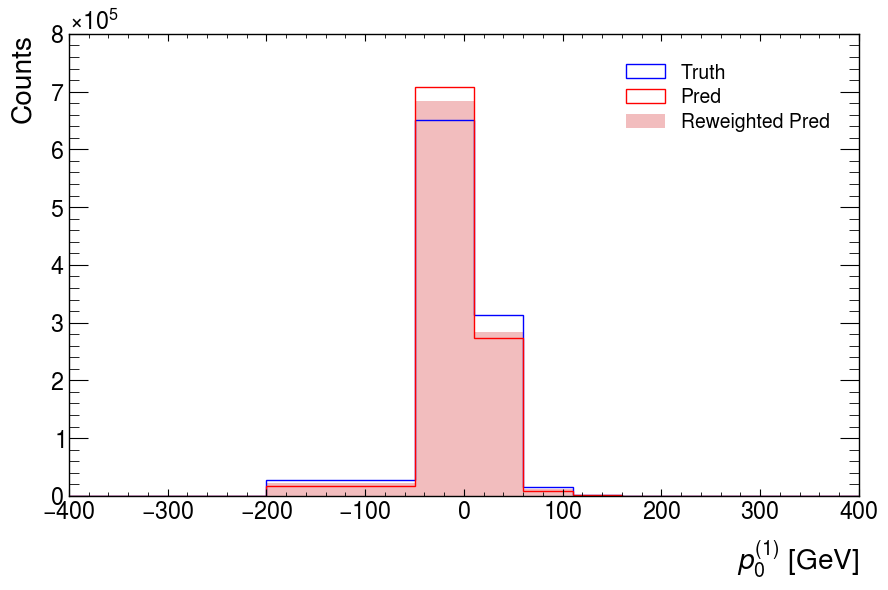

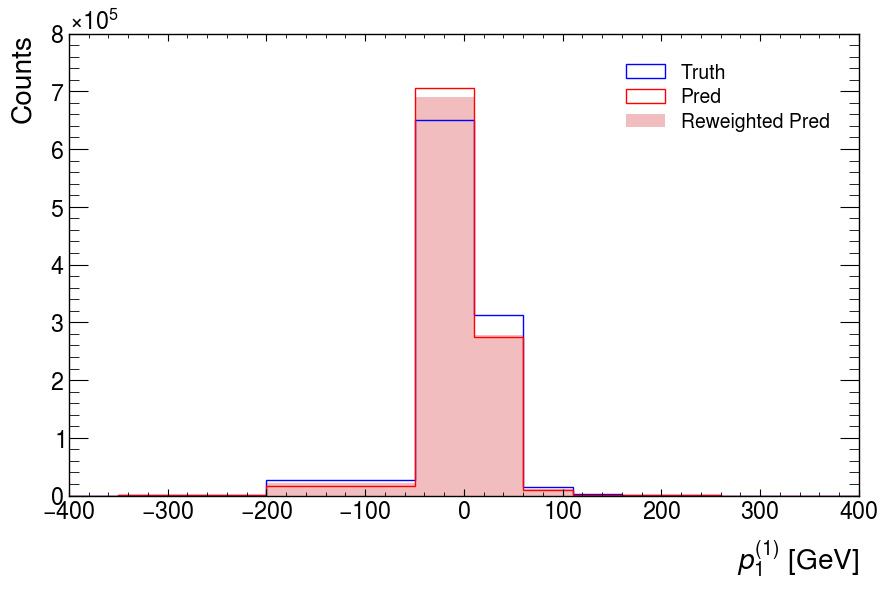

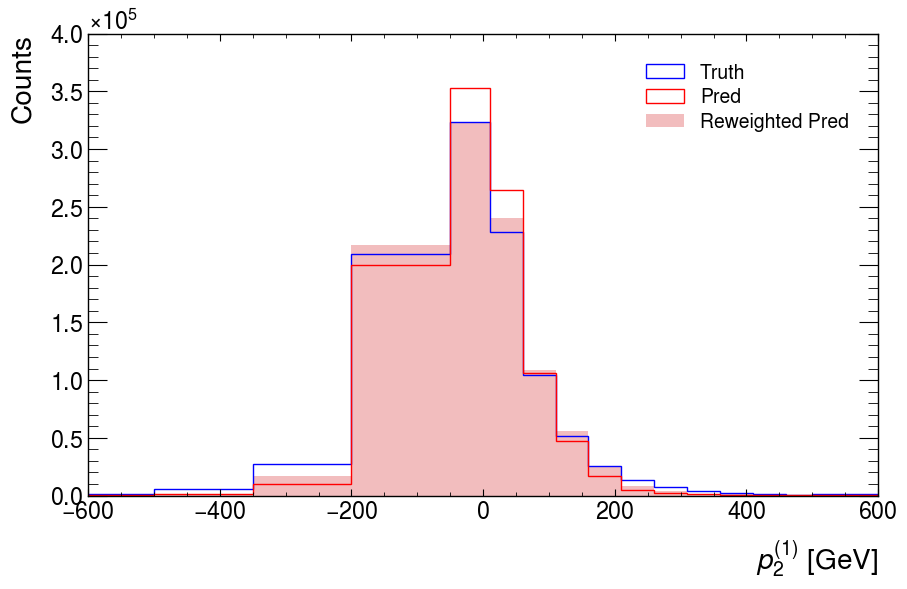

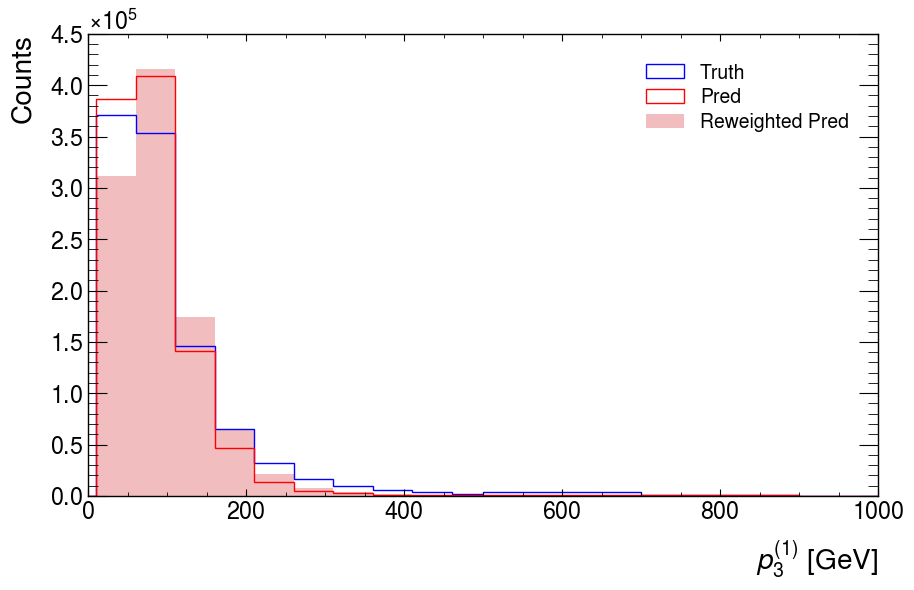

In [23]:
truth_hist = calculate_histograms(sig_truth_inv[:, 4:])
pred_hist = calculate_histograms(sig_pred_inv[:, 4:])
reweighted_hist = calculate_histograms(
    sig_pred_inv[:, 4:], weights=reweighting_coefficients
)

# Plot the histograms
plot_bins_range = [(-400, 400), (-400, 400), (-600, 600), (0, 1000)]
for dim in range(n_dims):
    plt.figure(figsize=(10, 6))
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=truth_hist[dim],
        histtype="step",
        label="Truth",
        color="blue",
        density=False,
    )
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=pred_hist[dim],
        histtype="step",
        label="Pred",
        color="red",
        density=False,
    )
    plt.hist(
        edges_w0[dim][:-1],
        bins=edges_w0[dim],
        weights=reweighted_hist[dim],
        histtype="bar",
        label="Reweighted Pred",
        color="tab:red",
        alpha=0.3,
        density=False,
    )
    # plt.semilogy()
    plt.xlim(plot_bins_range[dim])
    plt.xlabel(f"$p^{{(1)}}_{dim}$ [GeV]")
    plt.ylabel("Counts")
    plt.legend()
    plt.show()

In [68]:
cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))

0
29961
44269
89634
157782


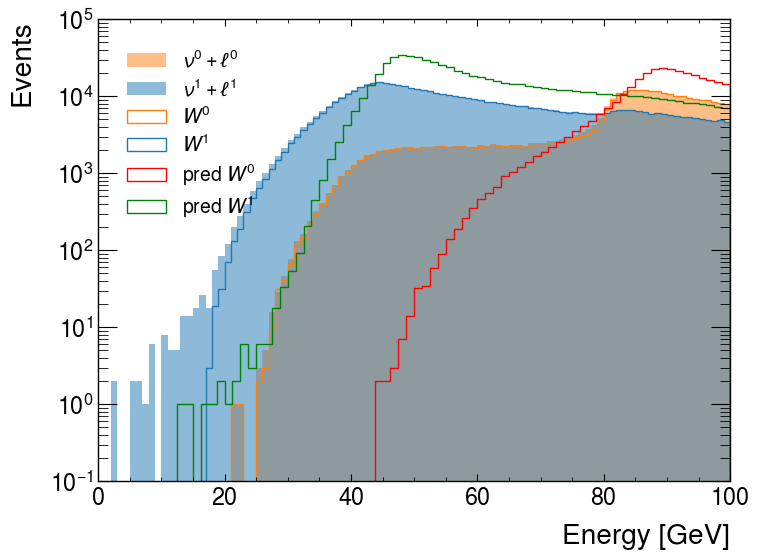

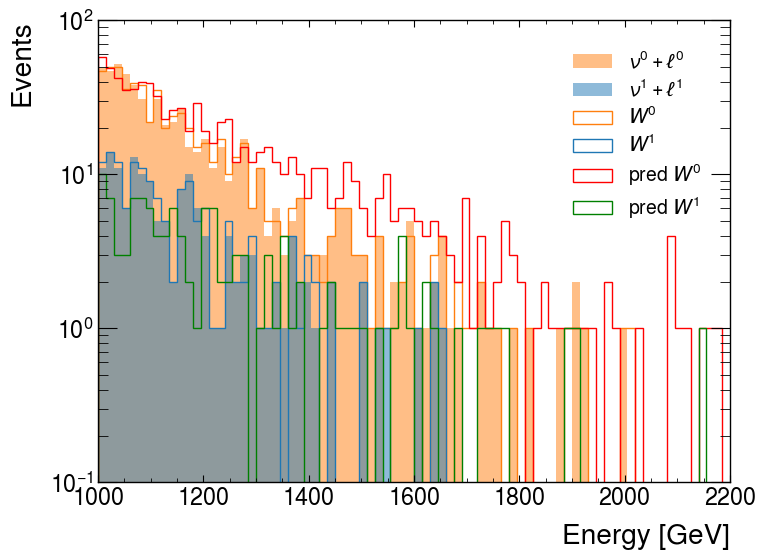

lead com min: 21.7069794921875
lead com max: 2304.673875
sublead com min: 2.3314295043945314
sublead com max: 1650.0396250000001
lead w min: 21.706978515625
lead w max 2304.674
sublead w min: 17.000962890625
sublead w max: 1650.061


In [69]:
# range of prediction checking


test_cut = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

(truth_lead_nu.energy[test_cut] + truth_lead_lep.energy[test_cut]).hist(
    bins=100, range=(0, 100), color="tab:orange", alpha=0.5, label=r"$\nu^{0}+\ell^{0}$"
)
# (truth_lead_nu.energy+ truth_lead_lep.energy).hist(bins=100, range=(0, 100), color="orange", alpha=0.5, label="test")
(truth_sublead_nu.energy[test_cut] + truth_sublead_lep.energy[test_cut]).hist(
    bins=100, range=(0, 100), color="tab:blue", alpha=0.5, label=r"$\nu^{1}+\ell^{1}$"
)
w_lead.energy[test_cut].hist(
    bins=100, range=(0, 100), color="tab:orange", histtype="step", label=r"$W^{0}$"
)
w_sublead.energy[test_cut].hist(
    bins=100, range=(0, 100), color="tab:blue", histtype="step", label=r"$W^{1}$"
)
plt.hist(
    sig_pred_inv[:, 3][test_cut],
    bins=80,
    range=(0, 100),
    color="red",
    histtype="step",
    alpha=1,
    label=r"pred $W^{0}$",
)
plt.hist(
    sig_pred_inv[:, 7],
    bins=80,
    range=(0, 100),
    color="green",
    histtype="step",
    alpha=1,
    label=r"pred $W^{1}$",
)
plt.grid(False)
plt.semilogy()
plt.legend()
# plt.semilogx()
plt.xlabel("Energy [GeV]")
plt.ylabel("Events")
plt.show()

(truth_lead_nu.energy[test_cut] + truth_lead_lep.energy[test_cut]).hist(
    bins=80,
    range=(1000, 2200),
    color="tab:orange",
    alpha=0.5,
    label=r"$\nu^{0}+\ell^{0}$",
)
(truth_sublead_nu.energy[test_cut] + truth_sublead_lep.energy[test_cut]).hist(
    bins=80,
    range=(1000, 2200),
    color="tab:blue",
    alpha=0.5,
    label=r"$\nu^{1}+\ell^{1}$",
)
w_lead.energy[test_cut].hist(
    bins=80, range=(1000, 2200), color="tab:orange", histtype="step", label=r"$W^{0}$"
)
w_sublead.energy[test_cut].hist(
    bins=80, range=(1000, 2200), color="tab:blue", histtype="step", label=r"$W^{1}$"
)
plt.hist(
    sig_pred_inv[:, 3],
    bins=80,
    range=(1000, 2200),
    color="red",
    histtype="step",
    alpha=1,
    label=r"pred $W^{0}$",
)
plt.hist(
    sig_pred_inv[:, 7],
    bins=80,
    range=(1000, 2200),
    color="green",
    histtype="step",
    alpha=1,
    label=r"pred $W^{1}$",
)

plt.grid(False)
plt.semilogy()
plt.legend()
# plt.semilogx()
plt.xlabel("Energy [GeV]")
plt.ylabel("Events")
plt.show()

print(
    "lead com min:",
    (truth_lead_nu.energy[test_cut] + truth_lead_lep.energy[test_cut]).min(),
)
print(
    "lead com max:",
    (truth_lead_nu.energy[test_cut] + truth_lead_lep.energy[test_cut]).max(),
)
print(
    "sublead com min:",
    (
        truth_sublead_nu.energy[test_cut] + truth_sublead_lep.energy[test_cut]
    ).min(),
)
print(
    "sublead com max:",
    (
        truth_sublead_nu.energy[test_cut] + truth_sublead_lep.energy[test_cut]
    ).max(),
)
print("lead w min:", w_lead.energy[test_cut].min())
print("lead w max", w_lead.energy[test_cut].max())
print("sublead w min:", w_sublead.energy[test_cut].min())
print("sublead w max:", w_sublead.energy[test_cut].max())

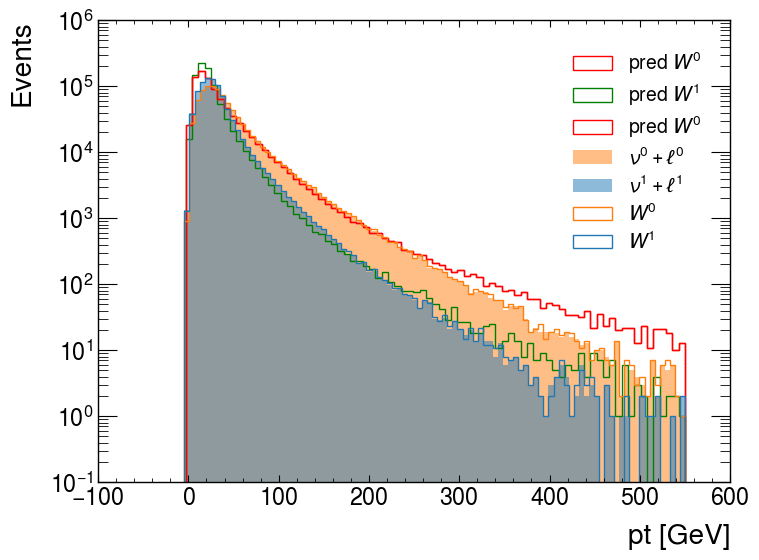

In [72]:
truth_lead_com_w_pt = data.pt(
    truth_lead_nu.px[test_cut] + truth_lead_lep.px[test_cut],
    truth_lead_nu.py[test_cut] + truth_lead_lep.py[test_cut],
)
truth_sublead_com_w_pt = data.pt(
    truth_sublead_nu.px[test_cut] + truth_sublead_lep.px[test_cut],
    truth_sublead_nu.py[test_cut] + truth_sublead_lep.py[test_cut],
)
w_lead_pt = data.pt(w_lead.px[test_cut], w_lead.py[test_cut])
w_sublead_pt = data.pt(w_sublead.px[test_cut], w_sublead.py[test_cut])
pred_lead_w_pt = data.pt(sig_pred_inv[:, 0][test_cut], sig_pred_inv[:, 1][test_cut])
pred_sublead_w_pt = data.pt(sig_pred_inv[:, 4][test_cut], sig_pred_inv[:, 5][test_cut])

plt.hist(
    pred_lead_w_pt,
    bins=80,
    range=(-10, 550),
    color="red",
    histtype="step",
    alpha=1,
    label=r"pred $W^{0}$"
)

plt.hist(
    pred_sublead_w_pt,
    bins=80,
    range=(-10, 550),
    color="green",
    histtype="step",
    alpha=1,
    label=r"pred $W^{1}$"
)

plt.hist(
    pred_lead_w_pt,
    bins=80,
    range=(-10, 550),
    color="red",
    histtype="step",
    alpha=1,
    label=r"pred $W^{0}$"
)

truth_lead_com_w_pt.hist(
    bins=100,
    range=(-10, 550),
    color="tab:orange",
    alpha=0.5,
    label=r"$\nu^{0}+\ell^{0}$",
)
# (truth_lead_nu.px+ truth_lead_lep.px).hist(bins=100, range=(0, 100), color="orange", alpha=0.5, label="test")
truth_sublead_com_w_pt.hist(
    bins=100, range=(-10, 550), color="tab:blue", alpha=0.5, label=r"$\nu^{1}+\ell^{1}$"
)
w_lead_pt.hist(
    bins=100, range=(-10, 550), color="tab:orange", histtype="step", label=r"$W^{0}$"
)
w_sublead_pt.hist(
    bins=100, range=(-10, 550), color="tab:blue", histtype="step", label=r"$W^{1}$"
)
plt.grid(False)
plt.semilogy()
plt.legend()
# plt.semilogx()
plt.xlabel("pt [GeV]")
plt.ylabel("Events")
plt.show()

In [27]:
# retraining the model with reweighted data


def dense_dropout_block(x, units, activation="elu", dropout_rate=0.2, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(l2=l2),
    )(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


def residual_block(x, units, activation="elu", dropout_rate=0.0, l2=0.0):
    x = dense_dropout_block(
        x, units, dropout_rate=dropout_rate, activation=activation, l2=l2
    )
    y = dense_dropout_block(
        x, units, dropout_rate=dropout_rate, activation=activation, l2=l2
    )
    z = tf.keras.layers.Add()([x, y])
    z = tf.keras.layers.Activation(activation)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    return z


def build_model():
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # construct the model
    for _ in range(5):
        x = residual_block(x, 256, dropout_rate=0.1, l2=0.0)
        x = residual_block(x, 32, dropout_rate=0.0, l2=0.0)  # 0.04

    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
reweighting_coefficients = digitize_data(int_kin[:, 0:4], rc_w0, edges_w0)
print(int_kin.shape)
model.summary()

(1008897, 8)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ activation[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 227,514 (888.73 KB)

 Trainable params: 74,792 (292.16 KB)

 Non-trainable params: 3,136 (12.25 KB)

 Optimizer params: 149,586 (584.32 KB)

In [30]:
# Compile the model
model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
)

# Early stopping and learning rate scheduler
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1 * LEARNING_RATE))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model using generators
history = model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    validation_data=(valid_x, valid_y),
    callbacks=[stop_early, lr_scheduler],
    verbose=2,
    sample_weight=reweighting_coefficients[train_indices],
)

Epoch 1/1024


I0000 00:00:1733851185.402797 2823613 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 4 bytes spill stores, 4 bytes spill loads



25223/25223 - 149s - 6ms/step - loss: 152.9360 - val_loss: 34.0346 - learning_rate: 5.0000e-04
Epoch 2/1024
25223/25223 - 138s - 5ms/step - loss: 146.3040 - val_loss: 34.8245 - learning_rate: 5.0000e-04
Epoch 3/1024
25223/25223 - 146s - 6ms/step - loss: 144.6942 - val_loss: 35.4648 - learning_rate: 5.0000e-04
Epoch 4/1024
25223/25223 - 137s - 5ms/step - loss: 143.2007 - val_loss: 34.9836 - learning_rate: 5.0000e-04
Epoch 5/1024
25223/25223 - 125s - 5ms/step - loss: 142.2996 - val_loss: 33.7740 - learning_rate: 5.0000e-04
Epoch 6/1024
25223/25223 - 161s - 6ms/step - loss: 141.8667 - val_loss: 35.3501 - learning_rate: 5.0000e-04
Epoch 7/1024
25223/25223 - 154s - 6ms/step - loss: 141.8010 - val_loss: 34.4598 - learning_rate: 5.0000e-04
Epoch 8/1024
25223/25223 - 145s - 6ms/step - loss: 140.9605 - val_loss: 33.8944 - learning_rate: 5.0000e-04
Epoch 9/1024
25223/25223 - 152s - 6ms/step - loss: 140.4713 - val_loss: 34.0681 - learning_rate: 5.0000e-04
Epoch 10/1024
25223/25223 - 155s - 6ms/st

In [31]:
# save modela
model.save(dir_name + name + "_reweighted.keras", save_format="keras", overwrite=True)
tf.saved_model.save(
    model, savedmodel_path
)  # save model in saved_model format --> use in the onnx

INFO:tensorflow:Assets written to: /root/work/QE-mls/8th_trial/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/8th_trial/ww_resregressor_result/saved_model/assets


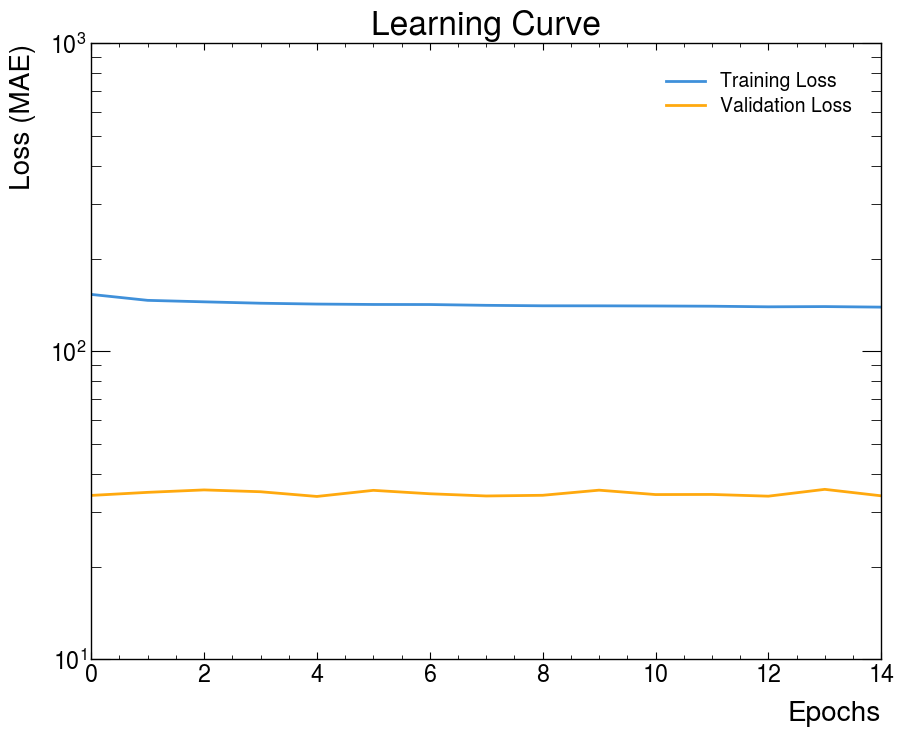

In [32]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot training and validation losses
plt.figure(figsize=(10, 8))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Learning Curve")
plt.legend()
plt.grid(False)
plt.show()

In [33]:
# predict
model = tf.keras.models.load_model(dir_name + name + "_reweighted.keras")
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(
    dir_name + name + "_reweighted_data.npz", pred_y=pred_y, test_y=test_y
)
sig_pred = np.load(dir_name + name + "_reweighted_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_reweighted_data.npz")["test_y"]

3153/3153 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [34]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_reweighted_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_reweighted_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_reweighted_data.npz")["test_y"]

Truth mean: -0.084, std: 39.028, min: -515.623, max: 622.445


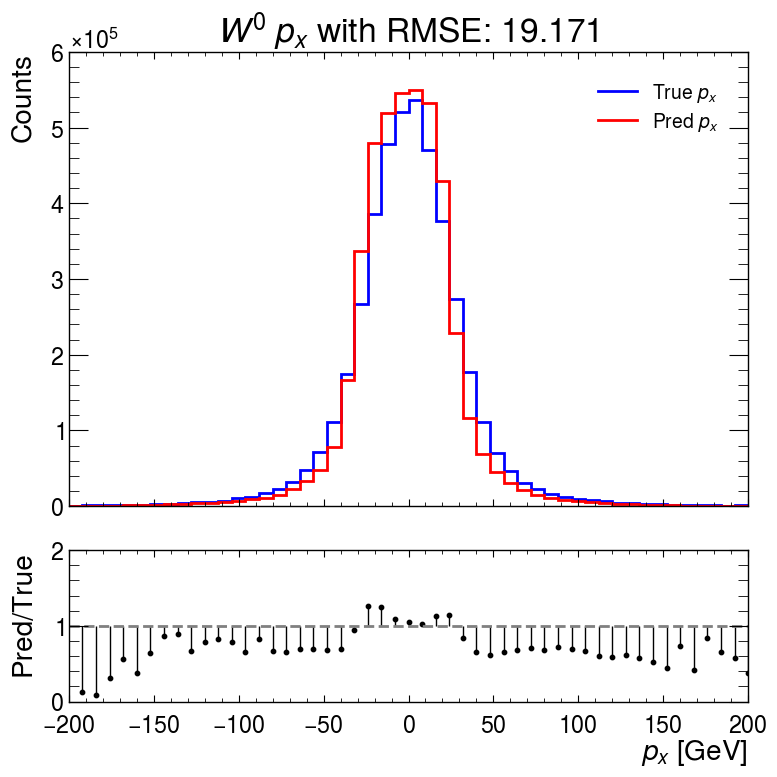

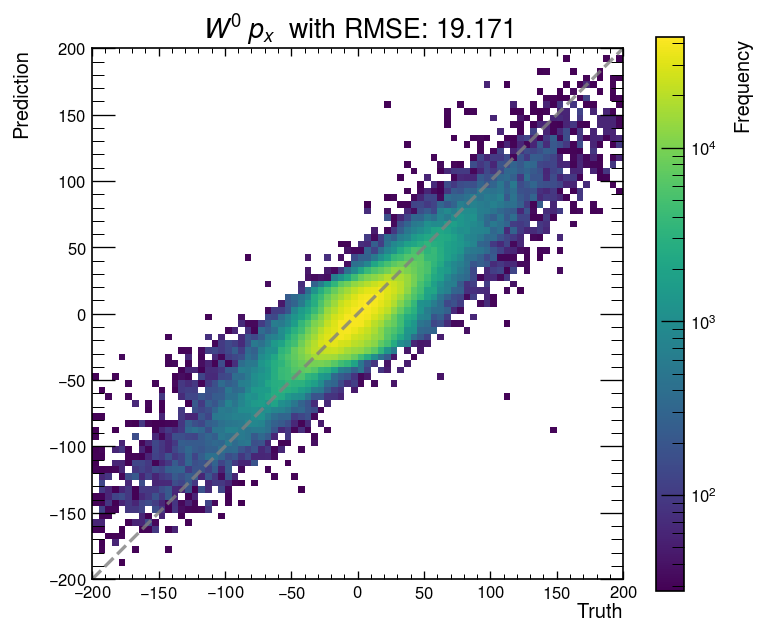

In [35]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$W^{0}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
    # bins = 50
)

Truth mean: -0.009, std: 38.797, min: -533.463, max: 596.260


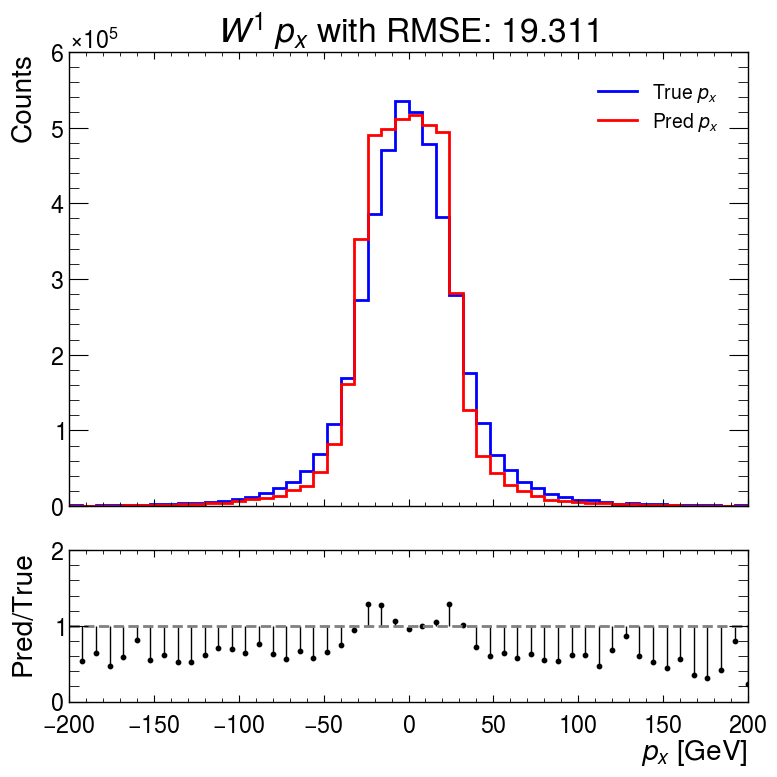

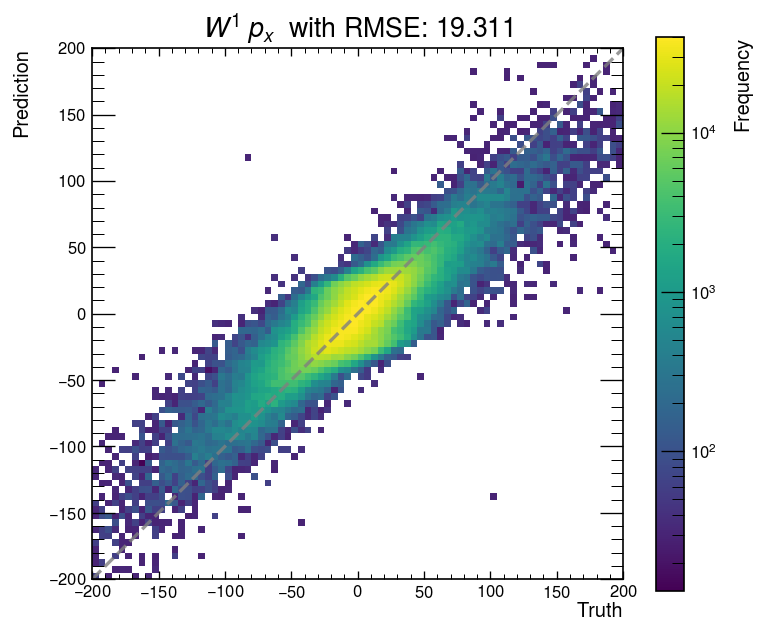

In [36]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{x}$",
    title="$W^{1}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{1}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
    # bins = 50
)

Truth mean: -0.009, std: 38.797, min: -533.463, max: 596.260


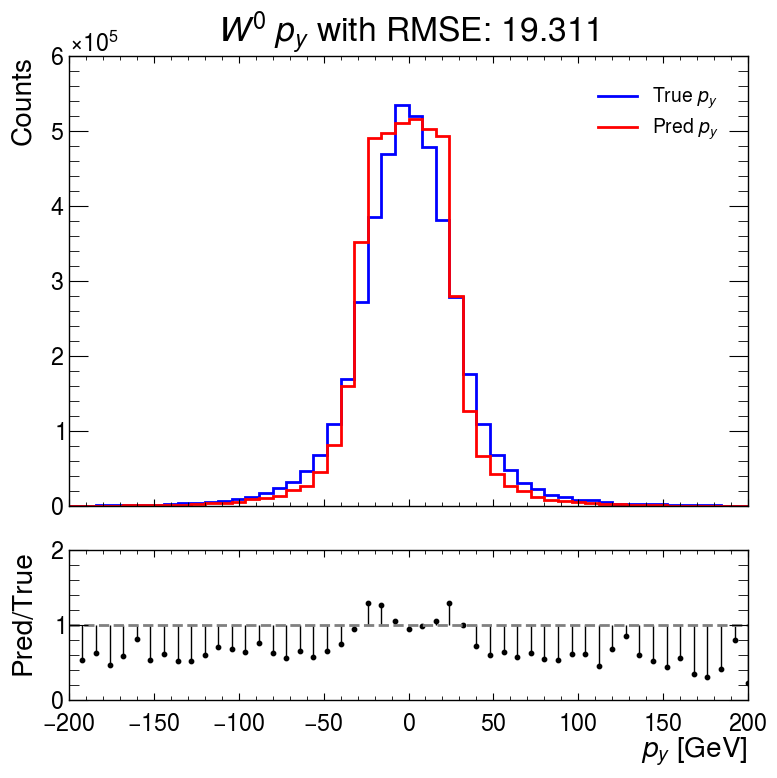

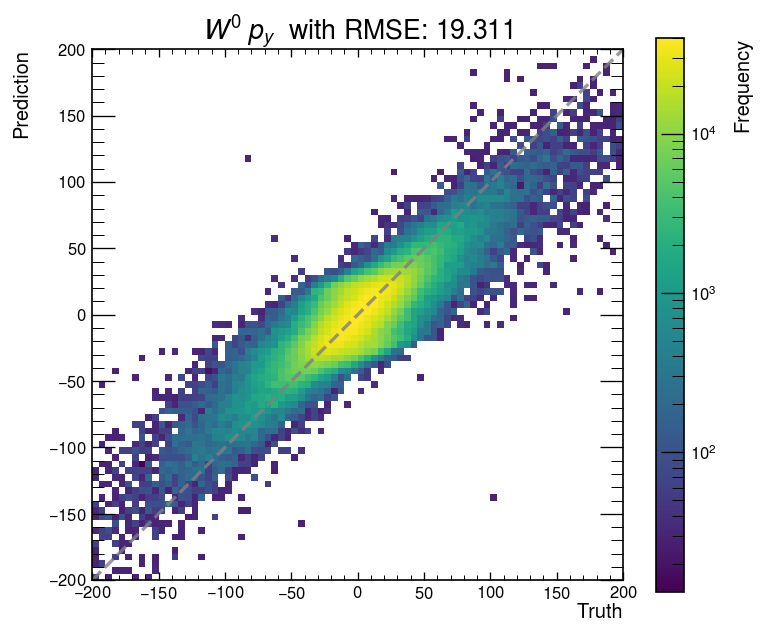

In [37]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{0}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

Truth mean: 0.042, std: 27.265, min: -344.483, max: 580.447


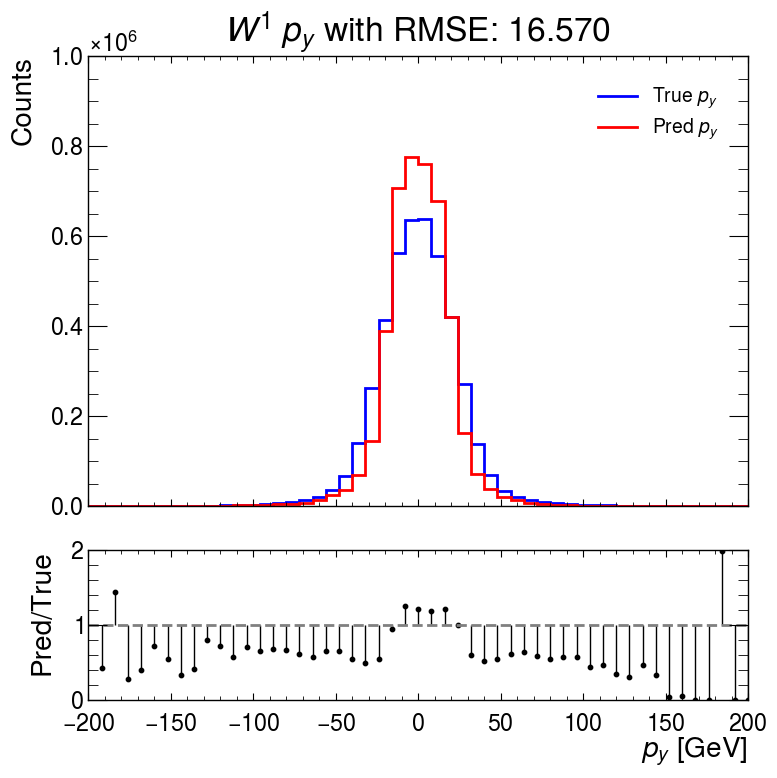

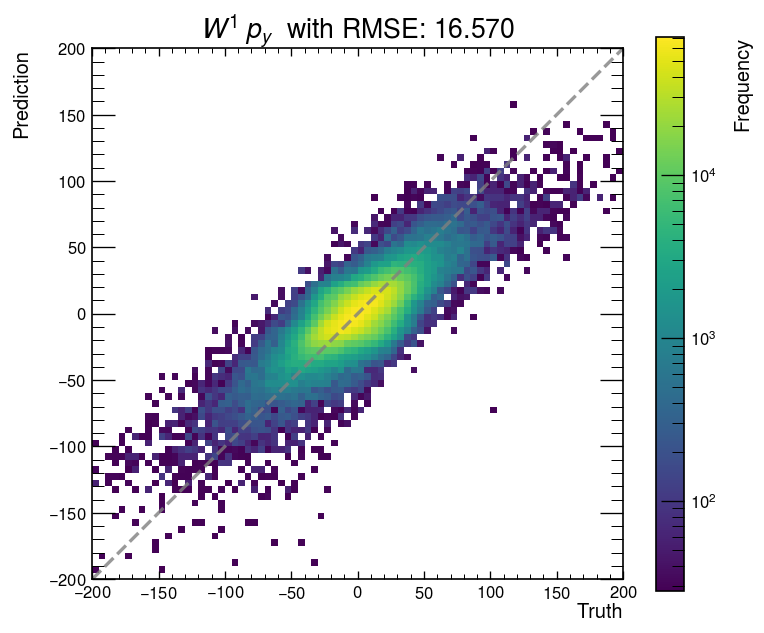

In [38]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}$",
    title="$W^{1}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"$W^{1}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

Truth mean: -1.138, std: 172.585, min: -1633.131, max: 1594.793


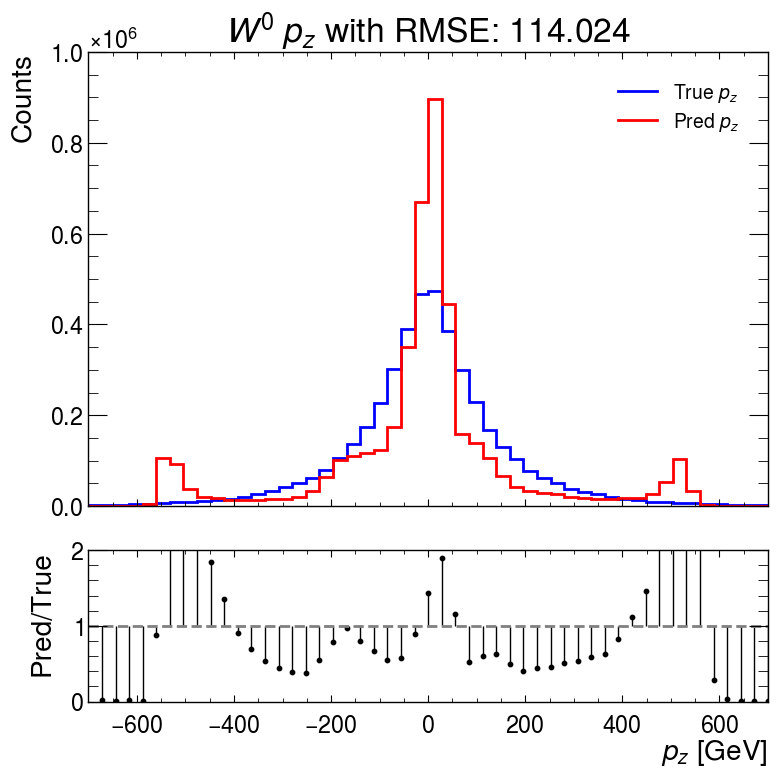

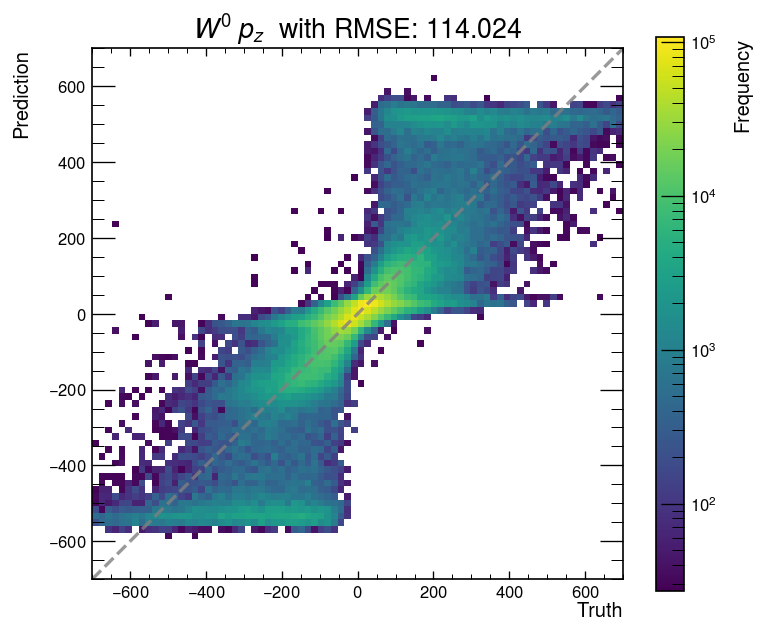

In [39]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$W^{0}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

Truth mean: -0.903, std: 111.860, min: -1278.261, max: 1427.069


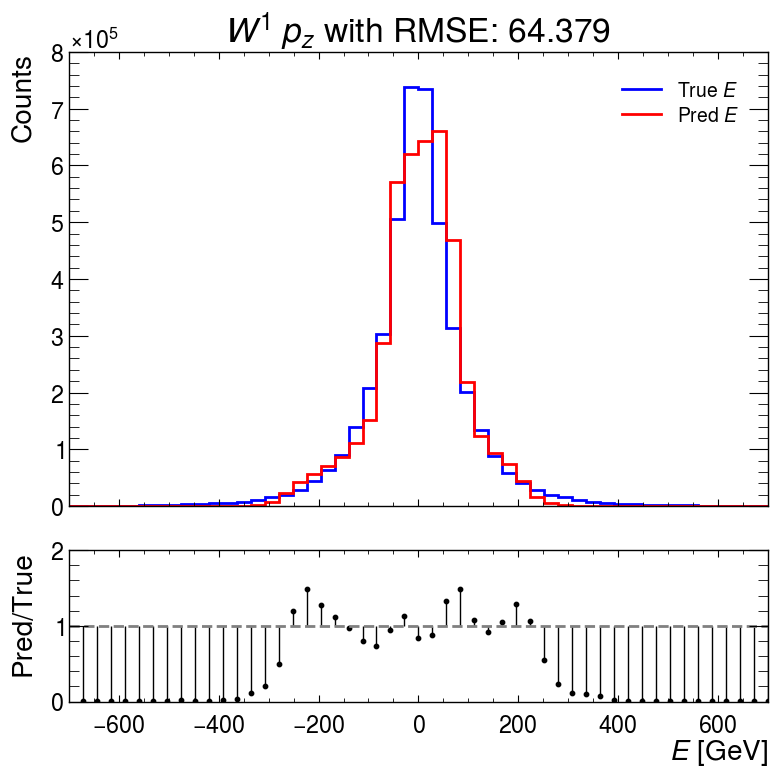

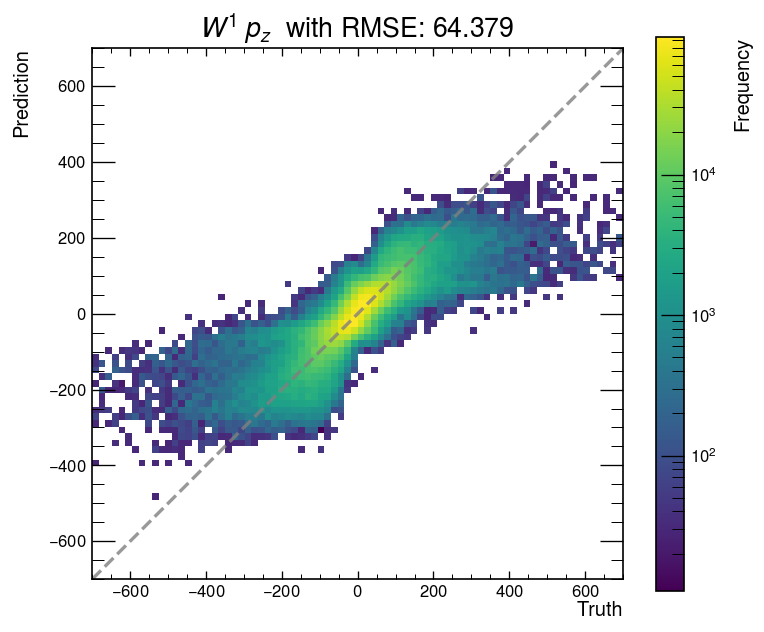

In [40]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$E$",
    title="$W^{1}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"$W^{1}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

Truth mean: 159.281, std: 112.898, min: 26.993, max: 1688.947


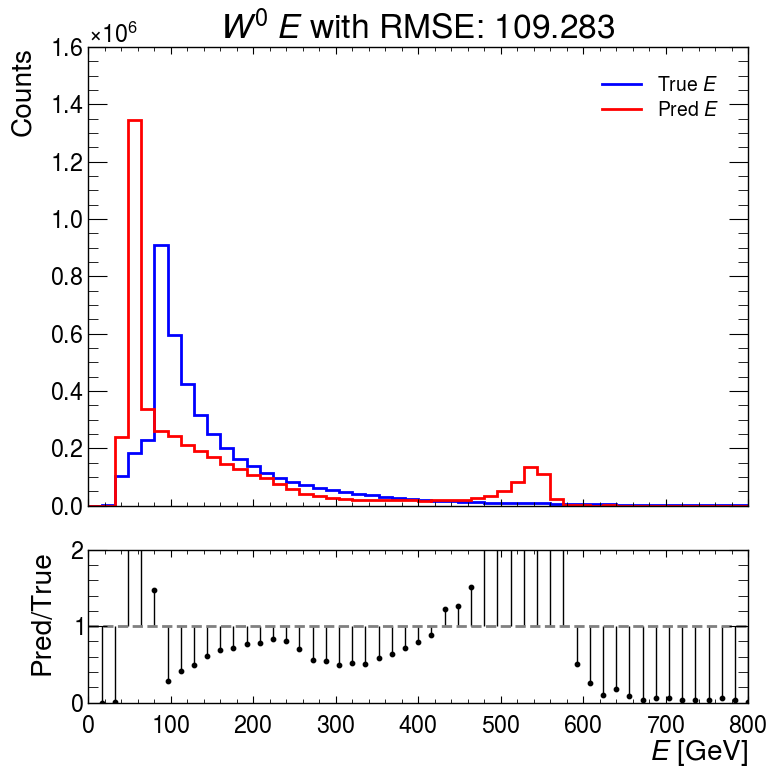

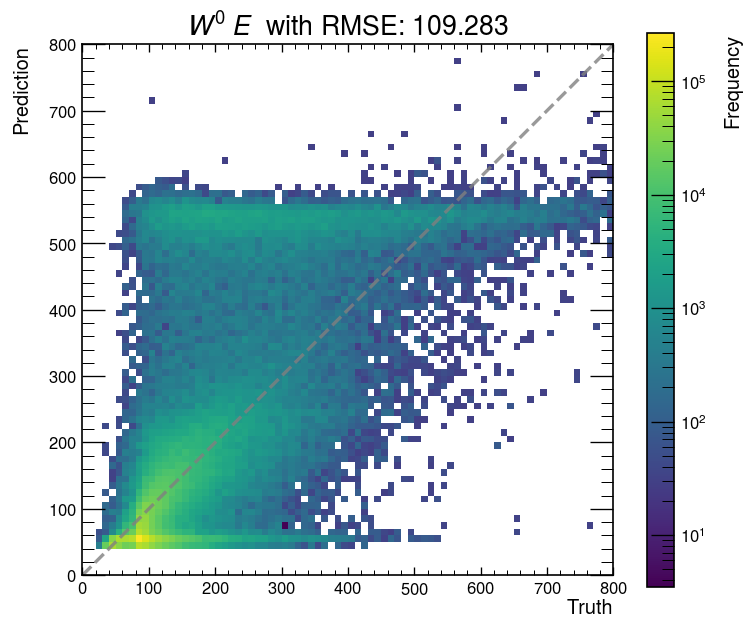

In [41]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$W^{0}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

Truth mean: 98.880, std: 78.447, min: 18.324, max: 1443.825


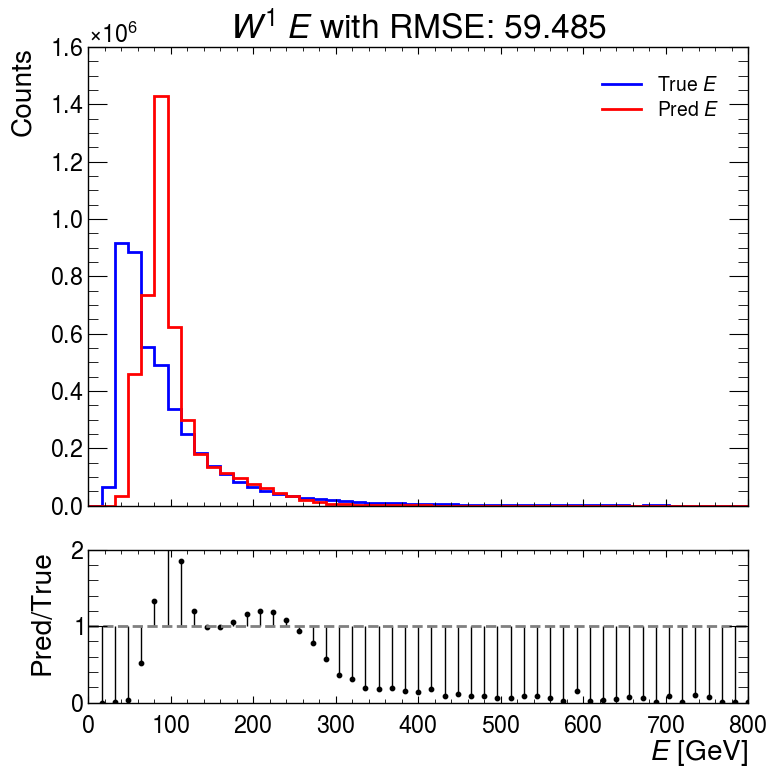

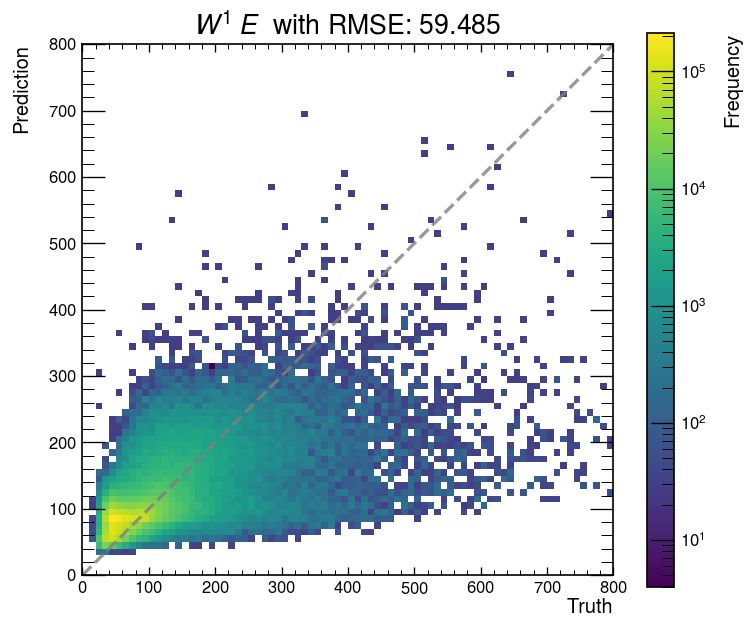

In [42]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="$W^{1}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=mc_weight[test_indices],
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"$W^{1}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=mc_weight[test_indices])):.3f}",
    range=set_range,
    weights=mc_weight[test_indices],
)

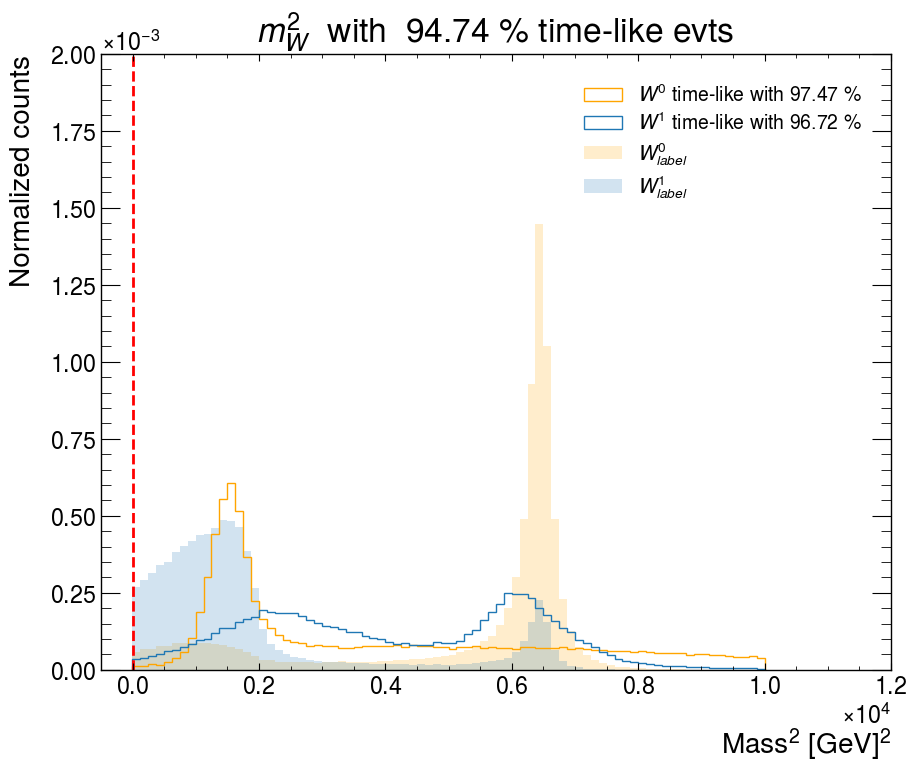

In [43]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$ "
    + f"time-like with {100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} %",
    density=True,
    weights=mc_weight[test_indices],
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$ "
    + f"time-like with {100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} %",
    density=True,
    weights=mc_weight[test_indices],
)
plt.hist(
    np.square(w_lead_m[test_indices]),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{0}$",
    density=True,
    weights=mc_weight[test_indices],
)
plt.hist(
    np.square(w_sublead_m[test_indices]),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{1}$",
    density=True,
    weights=mc_weight[test_indices],
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like evts"
)
plt.legend(loc="upper right")
plt.show()

Truth mean: 3616.331, std: 2592.917, min: 4.042, max: 10998.640


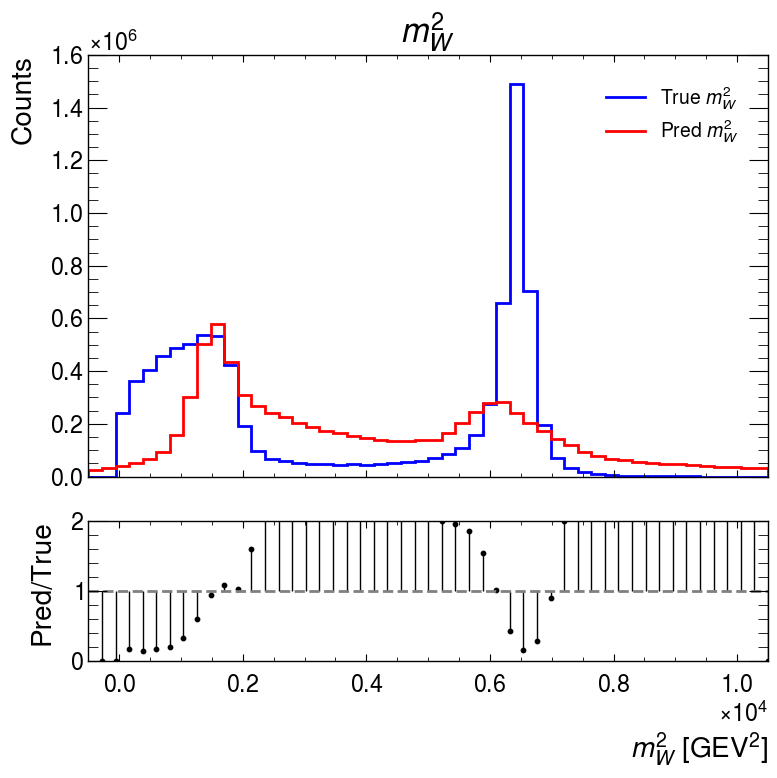

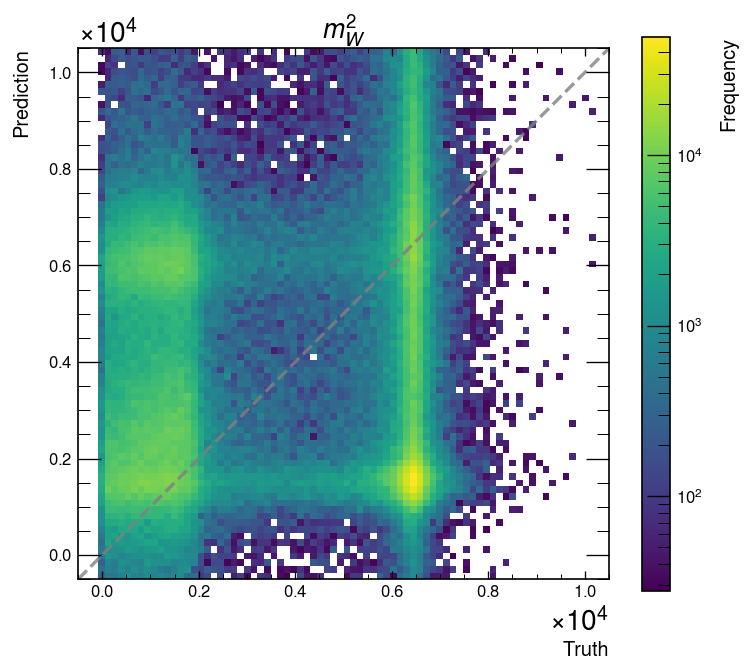

In [44]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead_m)[test_indices], np.square(w_sublead_m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
    weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
    weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)